In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw3.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 3: Artificial Neural Networks, Model Interpretation, and Regularization


**Harvard University**<br/>
**Spring 2023**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas

<hr style="height:2pt">

In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [3]:
import random
random.seed(109)

import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf

from sklearn.impute import KNNImputer

2023-03-09 19:22:13.391617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# measure notebook runtime
time_start = time.time()

<hr>

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so passing a test is necessary but not sufficient for full credit. 
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<hr>

<a id="contents"></a>

# Notebook Contents

- [**PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Questions](#part1questions)


- [**PART 2 [35 pts]: Kannada MNIST Kaggle competition**](#part2)
  - [Problem Statement](#part2intro)
  - [The Kannada MNIST Dataset](#part2about)
  - [Downloading the Data Files](#part2data)
  - [CS109B Kaggle Competition](#part2kaggle)
  - [Questions](#part2questions)


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description

[Return to contents](#contents)

In this problem, you will be building and interpreting models to predict whether a flight was delayed for its arrival. The model will be based on features that can be measured as the flight takes off.

We will also estimate the predictive intervals of the model using bootstrapping. We will utilize those predictive intervals to build a new kind of model: a model that refrains from making a prediction when it is not confident.

The variable in the original csv are:

    
**ARRIVAL_DELAY**: the difference between scheduled arrival and actual arrival, in minutes (positive is late, negative is early).

**DISTANCE**: the distance between arrival and departure airports, in miles.

**SCHEDULED_TIME**: the flight's scheduled travel time in minutes.

**MONTH**: the month the flight took off, 1 = January, 2 = February, etc.

**SCHED_DEP_HOUR**: the scheduled departure time (the hour of the day).

**SCHED_ARR_HOUR**: the scheduled arrival time (the hour of the day).

**FLIGHT_COUNT**: the number of flights flying out of the origin airport before noon on a typical day.

**DAY_OF_WEEK**: the day of the week, 1 = Monday, 2 = Tuesday, etc.

**ORIGIN_AIRPORT**: the airport the flight took off from.

**DESTINATION_AIRPORT**: the airport the flight was scheduled to land at.

For the airport codes, see: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes

To sucessfully complete this part, you will proceed by fitting a NN model, evaluating its accuracy, interpreting the predictors' importance, and finally evaluating the predictive intervals.

**NOTE:** the observations were sampled so that roughly half of the observations were delayed and half of the observations were not delayed.

<!-- </div> -->

<a id="part1solutions"></a>

## PART 1 Questions

[Return to contents](#contents)


<div class='exercise-r'>

**1.1**  **Preprocess the data**

Our first step will be to read in our dataset and preprocess our data.



</div>

<div class='exercise-r'>

**1.1.1**   Read in the dataset `data/flights.csv` into a DataFrame called `df_flights`. Create a new column in the DataFrame called `DELAY_OR_NOT`. This is a binary variable that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed by 15 minutes or more). This is going to be the response variable for the rest of part 1. 




</div>

In [5]:
# your code here 

df_flights = pd.read_csv("/Users/jamesliounis/Documents/Harvard SM DS/AC209b/Problem Sets/cs109b_hw3/data/flights.csv")

In [6]:
# your code here

delay = lambda x: 1 if x >= 15 else 0

df_flights['DELAY_OR_NOT'] = df_flights['ARRIVAL_DELAY'].map(delay)

In [7]:
grader.check("q1.1.1")

q1.1.1 results: All test cases passed!

<div class='exercise-r'>

**1.1.2 Preprocess the data**
    
- Deal with missing values if there are any
- One-hot-encode the non-numeric categorical variables
- Split the data using an 80/20 train-test split with `random_state=109` and stratifying on the response variable
- Standardize train and test with the scaler fit on the train data

Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets.
    
**NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.

**TIPS:** 
- month and day-of-the-week should be treated as numerical in this context.
- you should consider what predctors are acceptable to include given our goal is to predict if a flight is delayed.


</div>

We believe using KNNImputer may be a better alternative than dropping the rows to fill in the missing values as it is more interesting here to fill in these missing values using other features in the dataset rather than dropping them altogether. Also, it is particularly useful in cases where the missing data is in multiple features at once. 

This enables us to preserve the integrity and completeness of the original dataset, and it works very well in combination with other preprocessing techniques such as scaling, which we also use.  

In [8]:
# your code here

print(df_flights.isna().sum())

ARRIVAL_DELAY          0
DISTANCE               5
SCHEDULED_TIME         1
MONTH                  0
SCHED_DEP_HOUR         0
SCHED_ARR_HOUR         0
FLIGHT_COUNT           5
DAY_OF_WEEK            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
DELAY_OR_NOT           0
dtype: int64


In [9]:
# select rows with missing values
rows_with_missing_values = df_flights[df_flights.isnull().any(axis=1)]

# print the selected rows
print(rows_with_missing_values)

      ARRIVAL_DELAY  DISTANCE  SCHEDULED_TIME  MONTH  SCHED_DEP_HOUR  \
70               13       NaN           395.0     11               6   
1566             -4       NaN           418.0      2               6   
3741            -33       NaN           419.0     11              11   
5612             -9       NaN           381.0      6               8   
6375             17       NaN             NaN      7              18   

      SCHED_ARR_HOUR  FLIGHT_COUNT  DAY_OF_WEEK ORIGIN_AIRPORT  \
70                 9           NaN            1            BOS   
1566               9           NaN            5            BOS   
3741              15           NaN            2            BOS   
5612              12           NaN            5            BOS   
6375              21           NaN            3            BOS   

     DESTINATION_AIRPORT  DELAY_OR_NOT  
70                   SFO             0  
1566                 SFO             0  
3741                 SFO             0  
5612  

In [10]:
# one hot encode the categorical variable
df_flights = pd.get_dummies(df_flights, columns=['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'])

In [11]:
# create KNNImputer object and fit to data
imputer = KNNImputer(n_neighbors=2)
imputer.fit(df_flights)

# transform data with imputed values
df_flights = pd.DataFrame(imputer.transform(df_flights), columns=df_flights.columns)

There is only a handful of missing values in the dataframe and its only in variables that we hypothesize do not matter that much. Hence, we can probably just drop them without loss. 

In [12]:
# We check which types our columns have
# Need to OHE 'ORIGIN_AIRPORT' and 'DESTINATION_AIRPORT'

df_flights.dtypes

ARRIVAL_DELAY              float64
DISTANCE                   float64
SCHEDULED_TIME             float64
MONTH                      float64
SCHED_DEP_HOUR             float64
                            ...   
DESTINATION_AIRPORT_VLD    float64
DESTINATION_AIRPORT_VPS    float64
DESTINATION_AIRPORT_XNA    float64
DESTINATION_AIRPORT_YAK    float64
DESTINATION_AIRPORT_YUM    float64
Length: 812, dtype: object

In [13]:
y = 'DELAY_OR_NOT'

# split the data into training and testing sets
df_train, df_test = train_test_split(df_flights, 
                                     test_size=0.2, 
                                     random_state=109, 
                                     stratify=df_flights[y])

# Fit standard scaler on the training data
scaler = StandardScaler().fit(df_train)

df_train_scaled = pd.DataFrame(scaler.transform(df_train), columns=df_flights.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_flights.columns)

<div class='exercise-r'>

**1.2**  **Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation function for the hidden layers, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for a reasonable number of epochs. Feel free to use tensorflow's default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model`'s training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.

**Hint:** You should base your choice of "a reasonable number of epochs" on the visualization of the model's training history.

<a id="q13"></a>



</div>

In [14]:
# build your NN 
# your code here

# extract the predictor variables and response variable 
# from the training and testing sets
X_train = df_train_scaled.drop(y, axis=1)
y_train = pd.DataFrame(df_train_scaled[y])
X_test = df_test_scaled.drop(y, axis=1)
y_test = pd.DataFrame(df_test_scaled[y])

# define the ANN model

n_hidden = 2
hidden_size = 15
batch_size = 16

NN_model = tf.keras.Sequential()
NN_model.add(tf.keras.Input(shape=X_train.shape[1]))
for i in range(n_hidden):
    NN_model.add(tf.keras.layers.Dense(hidden_size, activation='sigmoid'))
NN_model.add(tf.keras.layers.Dense(2, activation='sigmoid'))


2023-03-09 19:22:24.833391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
from tensorflow.keras.utils import to_categorical

# convert y_train and y_test to one-hot encoded format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [16]:
# compile it and run it
# your code here 
# compile the model

NN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# plot train and val acc as a function of epochs
# your code here

# fit the model to the training data
history = NN_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
200/200 [==============================] - 1s 2ms/step - loss: 0.6895 - accuracy: 0.6000 - val_loss: 0.6436 - val_accuracy: 0.6875
Epoch 2/50
200/200 [==============================] - 0s 1ms/step - loss: 0.5814 - accuracy: 0.7606 - val_loss: 0.5425 - val_accuracy: 0.7588
Epoch 3/50
200/200 [==============================] - 0s 1ms/step - loss: 0.4561 - accuracy: 0.8136 - val_loss: 0.4737 - val_accuracy: 0.8025
Epoch 4/50
200/200 [==============================] - 0s 1ms/step - loss: 0.3594 - accuracy: 0.8578 - val_loss: 0.4264 - val_accuracy: 0.8325
Epoch 5/50
200/200 [==============================] - 0s 1ms/step - loss: 0.2837 - accuracy: 0.8947 - val_loss: 0.3810 - val_accuracy: 0.8600
Epoch 6/50
200/200 [==============================] - 0s 1ms/step - loss: 0.2197 - accuracy: 0.9216 - val_loss: 0.3422 - val_accuracy: 0.8869
Epoch 7/50
200/200 [==============================] - 0s 1ms/step - loss: 0.1672 - accuracy: 0.9444 - val_loss: 0.3096 - val_accuracy: 0.9044
Epoch 

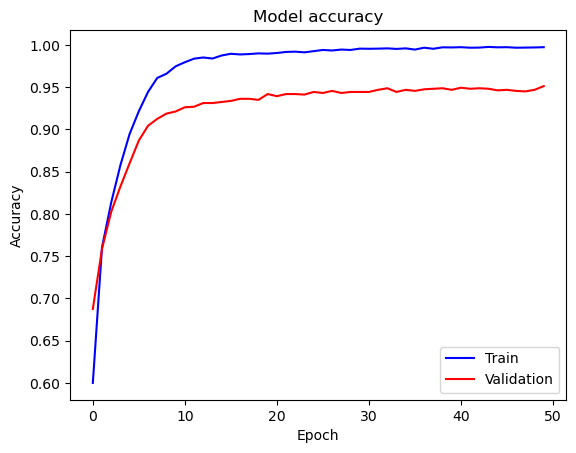

In [18]:
# evaluate on train and test and print accuracy results
# your code here 

# plot the training and validation accuracy as a function of epochs
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='red')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


In [19]:
# evaluate the model on the training data
train_loss, train_acc = NN_model.evaluate(X_train, y_train)
print('Train accuracy:', train_acc)

# evaluate the model on the test data
test_loss, test_acc = NN_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

250/250 [==============================] - 0s 862us/step - loss: 0.0740 - accuracy: 0.9896
Train accuracy: 0.9896249771118164
63/63 [==============================] - 0s 948us/step - loss: 0.2813 - accuracy: 0.9605
Test accuracy: 0.9605000019073486


<div class='exercise-r'>

**1.3**  **Fit and examine a "proxy" model**

Neural networks are often called 'black-box' models because it is difficult to interpret just what role each feature plays in the predictions they output. But suppose we choose a second type of model which is easier to interpret and train it to *predict the predictions* of the`NN_model`. That is, the response variable for the second, "proxy" model is the set of predictions generated by the `NN_model`, $\hat{y}$, **not** the true values, $y$. Interpreting this second, "proxy" model can then give us some insight into how the `NN_model` is making its predictions.




</div>

<div class='exercise-r'>

**1.3.1**  First, generate a set of `NN_model` class predictions for the training set. Call these `y_train_nn`. These $\hat{y}$ training predictions will be used instead of the true $y$ training values when we fit our proxy model in 1.3.2. The $X$ values used in our 1.3.2 proxy model should be the same ones used for `NN_model`.




</div>

In [20]:
# your code here
y_train_nn = (NN_model.predict(X_train) > 0.5).astype("int32")

250/250 [==============================] - 0s 671us/step


In [21]:
grader.check("q1.3.1")

q1.3.1 results: All test cases passed!

<div class='exercise-r'>

**1.3.2**  Next, fit a logistic regression model using your $\hat{y}$ values from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Next, print the `logreg` test accuracy compared to the *true $y$ values* to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.




</div>

In [22]:
from sklearn.linear_model import LogisticRegressionCV

In [23]:
y_train_nn = np.argmax(y_train_nn, axis=1)

In [24]:
# define a range of C values to test
c_values = [0.01, 0.5, 0.1, 0.2, 0.3]

# create a logistic regression object
logregcv = LogisticRegressionCV(Cs=c_values, penalty='l2', max_iter=1000)

# fit the logistic regression model to the training data
logregcv.fit(X_train, y_train_nn.ravel())

# get the best C value found by cross-validation
best_C = logregcv.C_[0]

In [25]:
# your code here

logreg = LogisticRegression(penalty = 'l2', C=best_C, max_iter=1000).fit(X_train, y_train_nn)

y_test_logreg = logreg.predict(X_test)
logreg_test_acc = accuracy_score(np.argmax(y_test, axis=1), y_test_logreg)
print("Logistic regression Test Accuracy: {:.2f}%".format(logreg_test_acc*100))
print("Previous Test Accuracy: {:.2f}%".format(test_acc*100))

Logistic regression Test Accuracy: 97.10%
Previous Test Accuracy: 96.05%


<div class='exercise-r'>

**1.3.3**  Now use sklearn's `permutation_importance` function (already included in this notebook's imports) to compute the feature importance using the `logreg` model. Plot the **relative** feature importance (normalizing your importances so that your largest importance equals 1 for comparison purposes) for the top-10 most important predictors identified by the `permutation_importance` function.

  - Please refer to sklearn's official documentation to learn how this function works.
  
  - When running `permutation_importance` for this problem, you can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.

<a id="q14"></a>



</div>

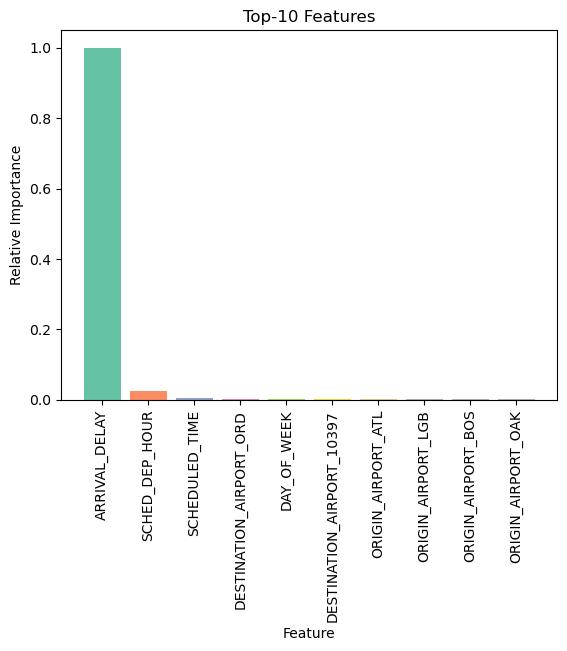

CPU times: user 3.64 s, sys: 591 ms, total: 4.23 s
Wall time: 51.8 s


In [26]:
%%time
# Compute permutation-based feature importances
result = permutation_importance(logreg, 
                                X_test, 
                                np.argmax(y_test, axis=1), 
                                n_repeats=10, 
                                random_state=0, 
                                n_jobs=-1)

importances = result.importances_mean

# Find indices of top-10 features
top_n = 10
idx = np.argsort(importances)[::-1][:top_n]

# Normalize importances and create color map
norm_imp = importances / importances.max()
colors = plt.cm.Set2(np.arange(top_n))

# Create bar plot with different colors for top features
plt.bar(range(top_n), norm_imp[idx], color=colors)
plt.xticks(range(top_n), X_train.columns[idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Relative Importance')
plt.title('Top-10 Features')
plt.show()

<div class='exercise-r'>

**1.4**  **Visualize important features** 

Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. Though the data has been scaled, **for all plots in 1.4, please visualize using the original scale for interpretability.**

**NOTE:** The predictors you are required to use in 1.4 may differ from some of the top-10 predictors you identified in 1.3 as a result of random variability in our algorithms.




</div>

<div class='exercise-r'>

**1.4.1**
    
Set all predictors to their means/modes except for `SCHED_DEP_HOUR` (when deciding between mean and mode, consider whether a given predictor is continous or categorical.
    
Next, predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences.

**NOTE:** Again, the values of `SCHED_DEP_HOUR` used her for predictions and plotting should be those actually *observed* in the training data.


</div>

The plot above indicates that the probability of delay increases in a nearly linear manner as the scheduled departure hour advances. This finding supports the previous plot, which emphasized the significance of this predictor over others. Moreover, the observation aligns with the intuition that departure hour is a key factor influencing delays.

In [27]:
relevant_predictors = ['SCHED_DEP_HOUR']
continuous_pred = ['DISTANCE', 'SCHEDULED_TIME', 'MONTH','SCHED_ARR_HOUR', 'FLIGHT_COUNT', 'DAY_OF_WEEK']
categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

X_temp = X_train.copy()

# Unscaled training and test data
df_train_unscaled = pd.DataFrame(scaler.inverse_transform(df_train_scaled), columns=df_flights.columns)

X_temp_unscaled = df_train_unscaled.drop(y, axis=1).copy()

for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()
        
for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()

250/250 [==============================] - 0s 706us/step


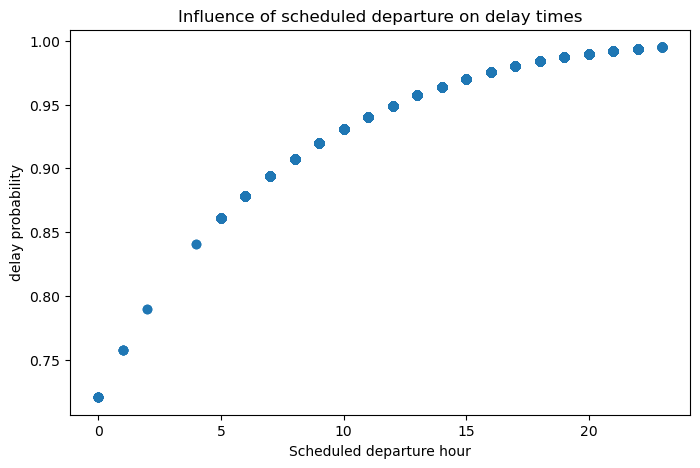

In [28]:
# prediction

delay_prob = [i[1] for i in NN_model.predict(X_temp)]


#delay_prob = np.argmax(delay_prob, axis=1)

plt.figure(figsize=(8, 5))
plt.scatter(X_temp_unscaled['SCHED_DEP_HOUR'], delay_prob)
plt.title('Influence of scheduled departure on delay times')
plt.xlabel('Scheduled departure hour')
plt.ylabel('delay probability')
plt.show()

<div class='exercise-r'>

**1.4.2**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. values `SCHED_DEP_HOUR` and `FLIGHT_COUNT` observed in the training set.  
    
**NOTE:** See hint in 1.4.5 about plotting in this section




</div>

In [29]:
# your code here
relevant_predictors = ['SCHED_DEP_HOUR', 'FLIGHT_COUNT']

continuous_pred = ['DISTANCE', 'SCHEDULED_TIME', 
                   'MONTH','SCHED_ARR_HOUR', 
                   'DAY_OF_WEEK']

categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

X_temp = X_train.copy()

# Unscaled training and test data
df_train_unscaled = pd.DataFrame(scaler.inverse_transform(df_train_scaled), columns=df_flights.columns)

X_temp_unscaled = df_train_unscaled.drop(y, axis=1).copy()

for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()
        
for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()

250/250 [==============================] - 0s 681us/step


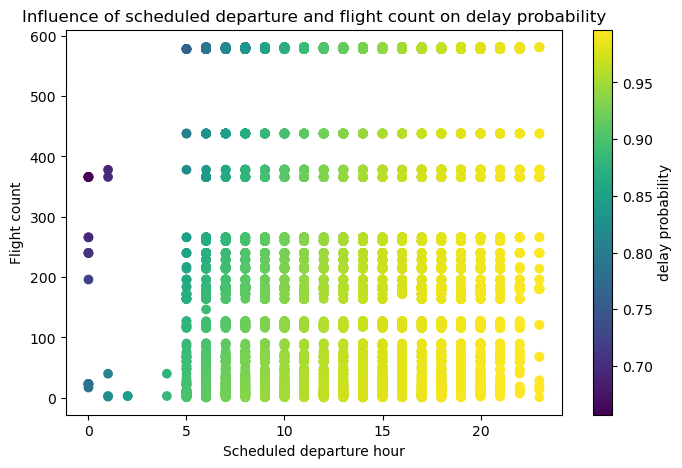

In [30]:
# your code here

# prediction

delay_prob = [i[1] for i in NN_model.predict(X_temp)]

fig, ax = plt.subplots(figsize=(8, 5))
scat = ax.scatter(X_temp_unscaled['SCHED_DEP_HOUR'],X_temp_unscaled['FLIGHT_COUNT'], c=delay_prob)
ax.set_title('Influence of scheduled departure and flight count on delay probability')
ax.set_xlabel('Scheduled departure hour')
ax.set_ylabel('Flight count')
fig.colorbar(scat, pad=0.05, label='delay probability')
plt.show()



<div class='exercise-r'>

**1.4.3**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. values of `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` observed in the training set.




</div>

In [31]:
# your code here
relevant_predictors = ['SCHED_DEP_HOUR', 'SCHED_ARR_HOUR']

continuous_pred = ['DISTANCE', 'SCHEDULED_TIME', 
                   'MONTH','FLIGHT_COUNT', 
                   'DAY_OF_WEEK']

categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

X_temp = X_train.copy()

# Unscaled training and test data
df_train_unscaled = pd.DataFrame(scaler.inverse_transform(df_train_scaled), columns=df_flights.columns)

X_temp_unscaled = df_train_unscaled.drop(y, axis=1).copy()

for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()
        
for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()

250/250 [==============================] - 0s 698us/step


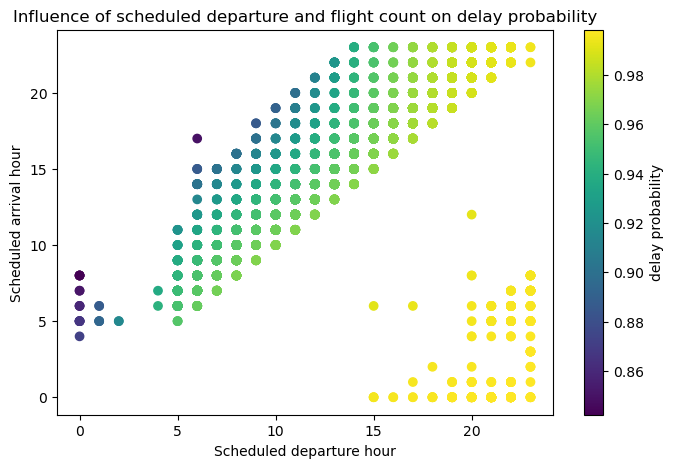

In [32]:
# prediction

delay_prob = [i[1] for i in NN_model.predict(X_temp)]

fig, ax = plt.subplots(figsize=(8, 5))
scat = ax.scatter(X_temp_unscaled['SCHED_DEP_HOUR'],X_temp_unscaled['SCHED_ARR_HOUR'], c=delay_prob)
ax.set_title('Influence of scheduled departure and flight count on delay probability')
ax.set_xlabel('Scheduled departure hour')
ax.set_ylabel('Scheduled arrival hour')
fig.colorbar(scat, pad=0.05, label='delay probability')
plt.show()

<div class='exercise-r'>

**1.4.4**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. values of `SCHED_DEP_HOUR` and `DISTANCE` observed in the training set. 




</div>

In [33]:
# your code here

relevant_predictors = ['SCHED_DEP_HOUR', 'DISTANCE']

continuous_pred = ['SCHEDULED_TIME', 
                   'MONTH','SCHED_ARR_HOUR', 
                   'DAY_OF_WEEK', 'FLIGHT_COUNT']

categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

X_temp = X_train.copy()

# Unscaled training and test data
df_train_unscaled = pd.DataFrame(scaler.inverse_transform(df_train_scaled), columns=df_flights.columns)

X_temp_unscaled = df_train_unscaled.drop(y, axis=1).copy()

for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()
        
for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()

250/250 [==============================] - 0s 674us/step


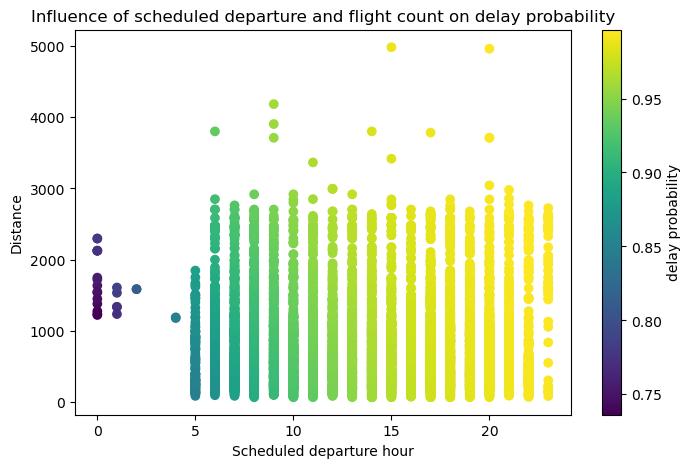

In [34]:
# prediction

delay_prob = [i[1] for i in NN_model.predict(X_temp)]

fig, ax = plt.subplots(figsize=(8, 5))
scat = ax.scatter(X_temp_unscaled['SCHED_DEP_HOUR'],X_temp_unscaled['DISTANCE'], c=delay_prob)
ax.set_title('Influence of scheduled departure and flight count on delay probability')
ax.set_xlabel('Scheduled departure hour')
ax.set_ylabel('Distance')
fig.colorbar(scat, pad=0.05, label='delay probability')
plt.show()

<div class='exercise-r'>

**1.4.5**  In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.

**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your data points based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. You can refer to the [matplotlib documentation](https://matplotlib.org/stable/tutorials/index) for examples. This [stackoverflow post](https://stackoverflow.com/questions/17682216/scatter-plot-and-color-mapping-in-python) covering color mapping with scatter plots may also be useful. 

<a id="q15"></a>



</div>

_Type your answer here, replacing this text._

<div class='exercise-r'>

**1.5**  **Bootstrap prediction intervals**

In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (the number of bootstraped *datasets*, $n$, should be at least 50). For each of the $n$ models, make predictions on the test data. Randomly select 8 test observations and on 8 subplots, plot the distribution of the $n$ predicted probabilities with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

<a id="q16"></a>



</div>

In [35]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

_Type your answer here, replacing this text._

In [36]:
# extract the predictor variables and response variable 
# from the training and testing sets
X_train = df_train_scaled.drop(y, axis=1)
y_train = pd.DataFrame(df_train_scaled[y])
X_test = df_test_scaled.drop(y, axis=1)
y_test = pd.DataFrame(df_test_scaled[y])

In [37]:
%%time
# Bootstrap and train your networks and get predictions on X test
# your code here

# NN model for bootstrap
n_bootstrap = 75

bootstap_preds = []

for k in range(n_bootstrap):
    progressbar(k, n_bootstrap)
    # build NN
    NN_boot = tf.keras.Sequential()
    for i in range(n_hidden):
        NN_boot.add(tf.keras.layers.Dense(hidden_size, activation='sigmoid'))
    NN_boot.add(tf.keras.layers.Dense(1, activation='relu'))
    #sample
    sample_idx = np.random.choice(X_train.index, size=len(X_train.index))
    X_sample = X_train.iloc[sample_idx]
    y_sample = y_train.iloc[sample_idx]

    # compile + fit
    NN_boot.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    NN_boot.fit(X_sample, y_sample, batch_size=32, epochs=10, validation_split=0.2, verbose=0)
    y_sample_pred = NN_boot.predict(X_test)
    bootstap_preds.append(y_sample_pred)

63/63 [==============================] - 0s 764us/step74/7
 [==================================================] 75/75 Done...

63/63 [==============================] - 0s 783us/step
CPU times: user 4min 45s, sys: 28 s, total: 5min 13s
Wall time: 4min 6s


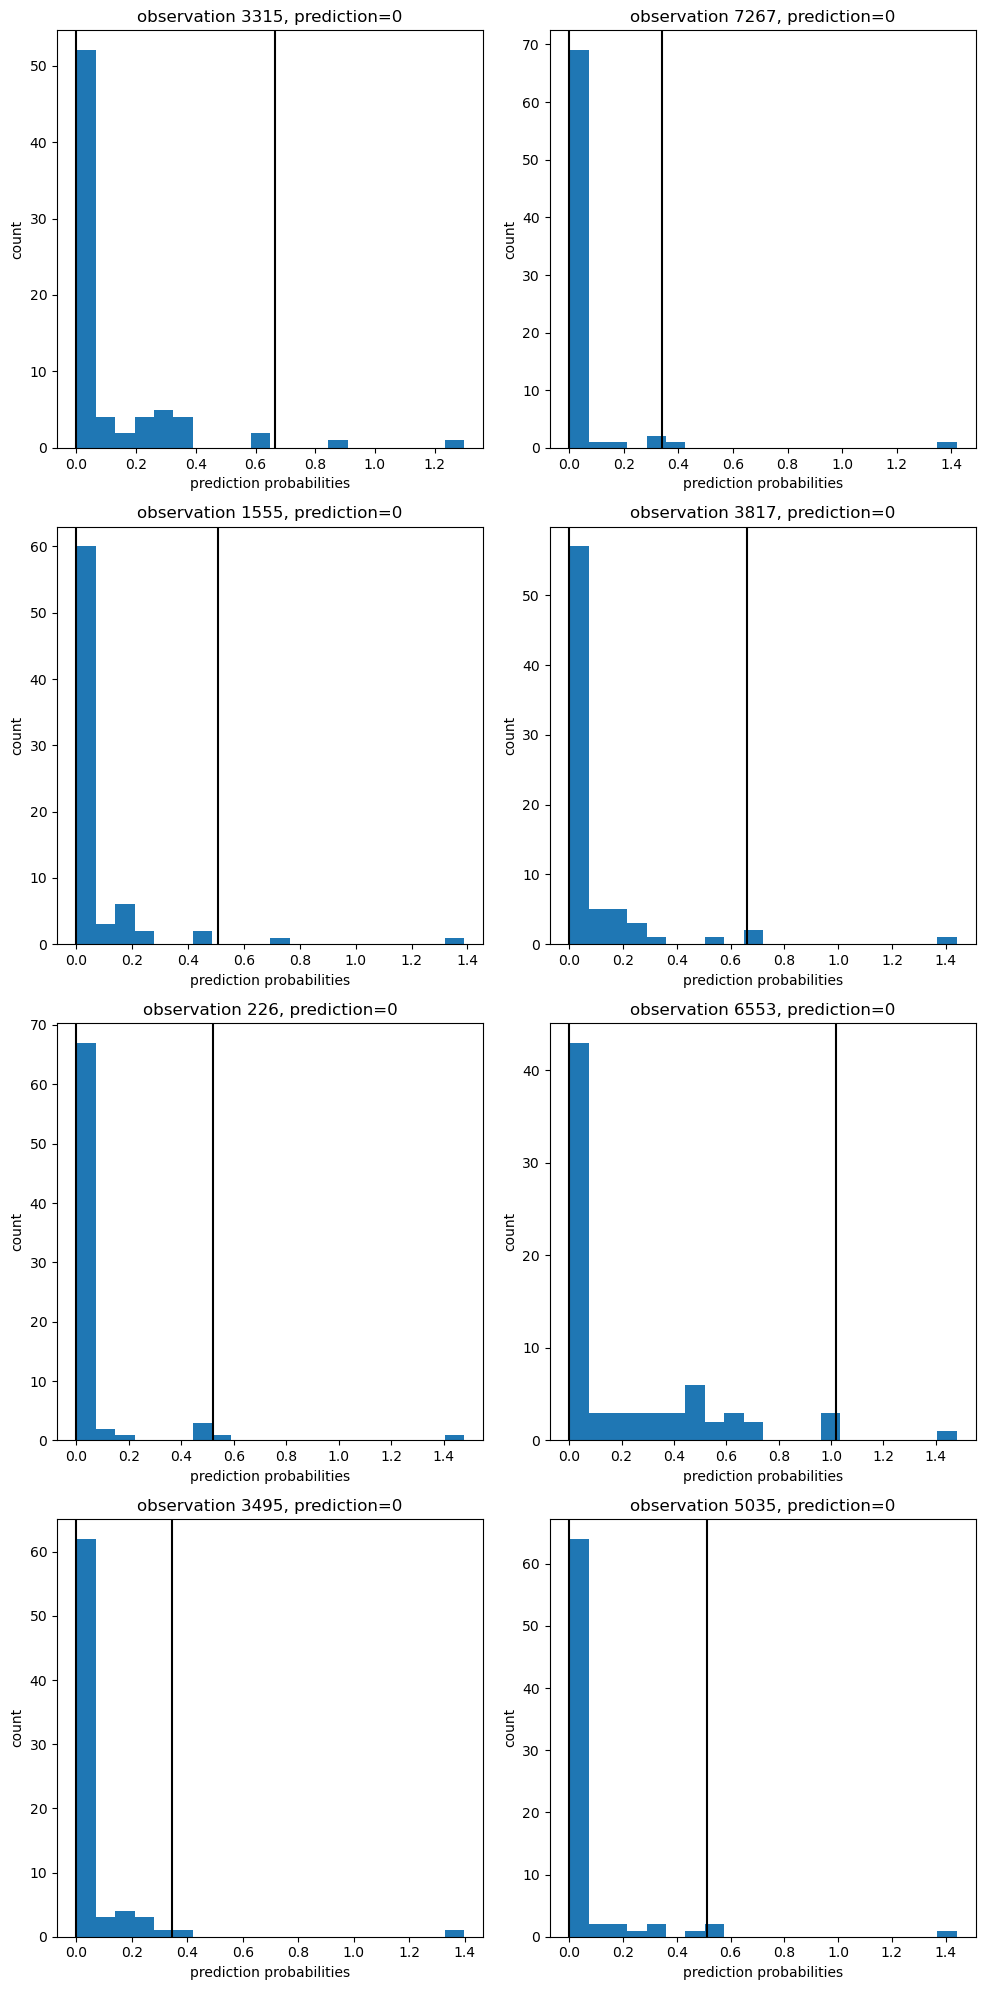

In [38]:
# generate your plot
# your code here

bootstap_preds = np.array(bootstap_preds).reshape(n_bootstrap, X_test.shape[0])
obs = [np.random.randint(X_train.shape[0]) for i in range(8)]

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10, 20))
axs = axs.flatten()
for i, o in enumerate(obs):
    obs_pred = bootstap_preds[:, i]
    # take bootstrap mean for prediction
    res = 1*(np.mean(obs_pred)>0.5)
    axs[i].hist(obs_pred, bins=20)
    axs[i].axvline(np.quantile(obs_pred, 0.025), color='black')
    axs[i].axvline(np.quantile(obs_pred, 0.975), color='black')
    axs[i].set_xlabel("prediction probabilities")
    axs[i].set_ylabel("count")
    axs[i].set_title("observation {}, prediction={}".format(o, res))
plt.tight_layout()
plt.show()

<div class='exercise-r'>

**1.6**  **Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how confident we should be in our bagged (i.e. bootstrap-aggregated) predictions for each test observation.

To accomplish this, you will first calculate a metric we'll call the **Posterior Prediction Dissent (PPD)** related to the proportion of predictions a given test observation receives for the minority opinion. Some examples: if 10% of the bootstrapped models predict $\hat{y} = 0$ with the remaining 90% predicting $\hat{y}=1$, then the $PPD=0.1$. When a bagged prediction's $PPD=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPD=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPD$ values for all test observations, you should have $n=2000$ $PPD$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for lack-of-confidence (i.e. maximum permissible $PPD$ value) is crossed. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPD$ threshold). You can make your abstain model *stricter* by using smaller $PPD$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPD$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPD$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPD$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model is permitted to predict on. 

**HINT:** 
- What is the range of values PPD can take on? Is it the same as the range of our predictions themselves?
- When calculating accuracies, you should only consider those observations that received predictions (i.e., not the abstained observations)
</div>

_Type your answer here, replacing this text._

In [39]:
y_test_pred = (NN_model.predict(X_test) > 0.5).astype("int32")
y_test_pred = np.argmax(y_test_pred, axis=1)

63/63 [==============================] - 0s 898us/step


Test bagging accuracy: 0.515


/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean o

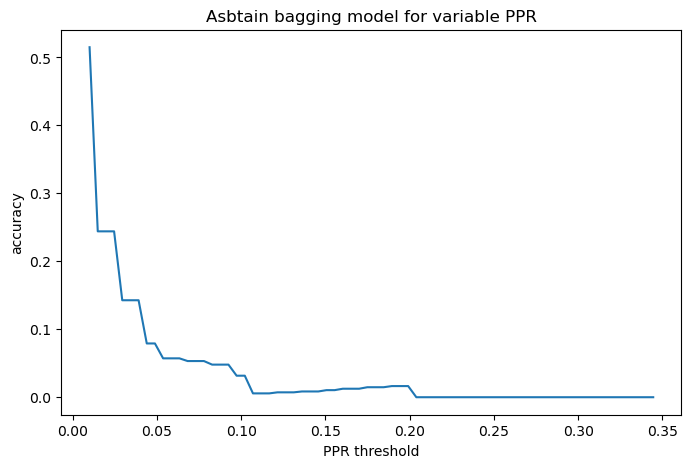

In [40]:
# your code here

v0 = np.sum(bootstap_preds<0.5, axis=0)
v1 = n_bootstrap - v0
v = np.stack((v0, v1))
PPR = np.min(v, axis=0)/n_bootstrap

bagg_pred = 1*(np.mean(bootstap_preds, axis=0)>0.5)
bagg_acc = accuracy_score(y_test_pred, bagg_pred)

y_test_pred = y_test_pred.flatten()
pred = 1*(np.mean(bootstap_preds, axis=0)>0.5)

print("Test bagging accuracy: {:.3f}".format(bagg_acc))
thresh = np.linspace(0.01, .49, 100)
kept = []
abs_bagg_acc = []

for t in thresh:
    to_keep = PPR>t
    kept.append(np.sum(to_keep))
    acc = accuracy_score(y_test_pred[to_keep], pred[to_keep])
    abs_bagg_acc.append(acc)

plt.figure(figsize=(8, 5))
plt.plot(thresh, abs_bagg_acc)
plt.xlabel("PPR threshold")
plt.ylabel("accuracy")
plt.title("Asbtain bagging model for variable PPR")
plt.show()

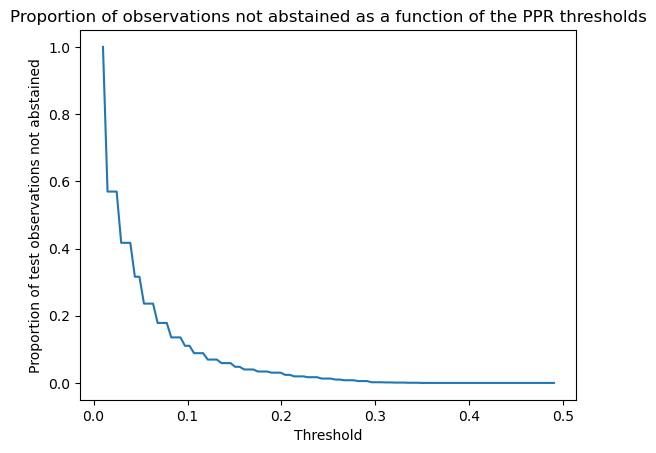

In [41]:
# your code here
plt.plot(thresh,np.array(kept)/len(y_test))
plt.xlabel("Threshold")
plt.ylabel("Proportion of test observations not abstained")
plt.title("Proportion of observations not abstained as a function of the PPR thresholds")
plt.show()

In [42]:
# your code here
...

<a id="part2"></a>

<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [35 pts]: Kannada MNIST Kaggle competition

[Return to contents](#contents)


<a id="part2intro"></a>

## Problem Statement

[Return to contents](#contents)


Artificial neural networks (ANNs) can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns do not generalize to new data.

There are several methods used to improve ANN generalization. 

One approach is to use an architecture just barely wide or deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and it is computationally costly to hunt for the correct size. Given this, other methodologies are used to prevent overfitting and improve ANNs' generalizability. These methodologies, like other techniques that combat overfitting, fall under the umbrella term of "regularization".

In this problem, you are asked to regularize a network of a given architecture.

<a id="part2about"></a>

## The Kannada MNIST Dataset

[Return to contents](#contents)


![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F1e01bcc28b5ccb7ad38a4ffefb13cde0%2Fwondu.png?generation=1603204077179447&alt=media)


For this problem, we will be working with a modified version of the [Kannada MNIST dataset](https://arxiv.org/pdf/1908.01242.pdf), which is a large database of handwritten digits in the indigenous language *Kannada*.

This dataset consists of 60,000 28x28 grayscale images of the ten digits, along with a test set of 10,000 images. 

For this homework, we will simplify the problem by only using the digits labeled `0` and `1` owing to the similarity of the two symbols, and we will use a total of 1,200 samples for training (this includes the data you will use for validation).

To understand the dataset better, we recommend this [article](https://towardsdatascience.com/a-new-handwritten-digits-dataset-in-ml-town-kannada-mnist-69df0f2d1456) by Vinay Prabhu, the curator of the dataset.

<a id="part2data"></a>

## Downloading the Data Files

[Return to contents](#contents)


**Please download the specific `kmnist_train.csv` and `kmnist_test.csv` data files available on [the "Data" tab of the CS109B HW3 Kaggle Competition website](https://www.kaggle.com/t/91152696a0cf4872adedafbaff0f7f15). (DO NOT USE DATA FROM ANY OTHER SOURCE!)**

Here's a brief description of the data files:

- `kmnist_train.csv` is our training dataset and the last column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image. Class 0 means a sample is the handwritten digit `0` and class 1 means a sample is the handwritten digit `1` in the Kannada written language. `kmnist_train.csv` has 1,200 samples.


- `kmnist_test.csv` has a structure similar to `kmnist_train.csv`, however the class label column is NOT included in with the test set. `kmnist_test.csv` has 2,000 samples. 


Kaggle leaderboard scores are accuracy scores calculated by Kaggle when you upload your predictions on this test set.

- `sample_submission.csv` is the format that kaggle will accept. The uploaded `.csv` must contain 2 columns. The first column must be named `id` and needs to contain the test observation index numbers for each prediction, the second must be named `category` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. 

<a id="part2kaggle"></a>

## CS109B Kaggle Competition

[Return to contents](#contents)

**ACCESS AND JOIN THE COMPETITION**:

**You need to create an account on Kaggle and [join the competition via this link](https://www.kaggle.com/t/91152696a0cf4872adedafbaff0f7f15). This is a limited participation competition. Please DO NOT share this link.**

**For more information on the rules** governing this CS109B Kaggle competition, please see below and also review [the modelling restrictions DOS and DON'TS outlined in question 2.3.1](#q2.3.1).

**IMPORTANT NOTES ABOUT SCORING**:

- The **public leaderboard** on Kaggle displays your performance on only 30% of the test set.


- After the competition is complete, the **private leaderboard** will show your performance on the remaining 70% of the test set.

- Question 2.3.5 is worth 5 points (the entire notebook is scored out of 100). Points for this questions will be awarded based on the **private leaderboard** as follows.

|Private Leaderboard Score   | Points|
|----------------------------|-------|
|$0.945 \leq \text{score}$ |5|
|$0.944 \leq \text{score} \lt 0.945$|4|
|$0.93 \leq \text{score} \lt 0.94$|3|
|$0.92 \leq \text{score} \lt 0.93$|2|
|$0.889 \leq \text{score} \lt 0.92$|1|

**🏆 Grand Prize(s):** The **Top-4** students on the private leaderboard will win an invitation to dinner with Pavlos and some of the CS109B teaching staff. This refers to the top 4 individuals on the board. The invitation will be extended to 5 students if the restriction to 4 would otherwise divide a group (e.g., 3 single submissions at the top followed by a group of 2).

**ADDITIONAL COMPETITION RULES:**

- Multiple Kaggle submissions are permitted (with a maximum of 20 submissions per-participant per-day), **just note that you will need to choose, on Kaggle, the ONE single submission to use for final scoring prior to the final HW3 submission deadline**, and **your submitted notebook MUST contain the matching code and model that generated your ONE chosen submission.**


- **To repeat this point, the version of your final HW3 notebook submitted on Canvas MUST contain the same code and exact same model used to generate your ONE chosen Kaggle submission.** (TFs may rerun your notebook code to ensure comparable final leaderboard results.)


- **Please do not manually label your submissions.** In other words, the labels should only be the outcome of your model.


- **No external data are allowed, you MUST USE ONLY the KMNIST training and test data downloaded via the "Data" tab of [the CS109B competition page linked above](#part2data).**


- **Do not** create multiple accounts on Kaggle.


<div class='exercise-r'>

**2.1**  **Get and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1 from the training set.
- You are responsible for any preprocessing you deem necessary to help in your prediction task.

<a id="q22"></a>



</div>

In [43]:
# your code here
df_train = pd.read_csv("/Users/jamesliounis/Documents/Harvard SM DS/AC209b/Data/kmnist_train.csv")
df_test = pd.read_csv("/Users/jamesliounis/Documents/Harvard SM DS/AC209b/Data/kmnist_test.csv")

In [44]:
# your code here
x_train, y_train = df_train.drop(["output"],axis=1), df_train["output"]
x_test = df_test

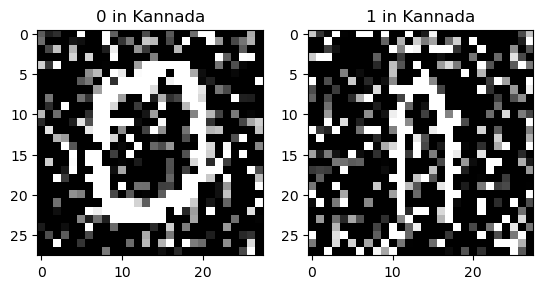

In [45]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.reshape(x_train.loc[2].values,(28,28)),cmap="gray")
ax[0].set_title("0 in Kannada")
#plt.savefig(path+'kmnist_train.jpg', dpi=300, format='jpg', bbox_inches='tight')
ax[1].imshow(np.reshape(x_train.loc[0].values,(28,28)),cmap="gray")
ax[1].set_title("1 in Kannada")
#plt.savefig(path+'kmnist_train.jpg', dpi=300, format='jpg', bbox_inches='tight')
plt.show()

<div class='exercise-r'>

**2.2**  **Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 1,000
- Batch size: 128
- Validation size: 0.3

![diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 




</div>

**Answer to Q2.2**

One can observe that the model is overfitting when the training accuracy reaches 100% and stops changing after just a few epochs. Additionally, the validation accuracy remains relatively low and remains nearly constant after approximately 300 epochs.

In [46]:
# your code here
inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100,activation="relu")(inputs)
x = tf.keras.layers.Dense(100,activation="relu")(x)
x = tf.keras.layers.Dense(100,activation="relu")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model_overfit = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model_overfit")
#model_overfit.summary()
model_overfit.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])

In [47]:
%%time 
# your code here
N_eps = 1000
history=model_overfit.fit(x_train,y_train,epochs=N_eps,batch_size=128,validation_split=0.3)

Epoch 1/1000
7/7 [==============================] - 1s 32ms/step - loss: 10.1160 - accuracy: 0.5667 - val_loss: 4.1659 - val_accuracy: 0.5528
Epoch 2/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.1730 - accuracy: 0.6345 - val_loss: 1.9547 - val_accuracy: 0.6222
Epoch 3/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.2582 - accuracy: 0.6702 - val_loss: 0.8936 - val_accuracy: 0.7167
Epoch 4/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.7870 - accuracy: 0.7262 - val_loss: 0.6322 - val_accuracy: 0.7583
Epoch 5/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.6604 - accuracy: 0.7429 - val_loss: 0.6333 - val_accuracy: 0.7500
Epoch 6/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.5482 - accuracy: 0.7702 - val_loss: 0.5832 - val_accuracy: 0.7611
Epoch 7/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.3777 - accuracy: 0.8560 - val_loss: 0.5583 - val_accuracy: 0.7944
Epoch 8/1000
7/7 [

7/7 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3918 - val_accuracy: 0.9000
Epoch 60/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3891 - val_accuracy: 0.9000
Epoch 61/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.4092 - val_accuracy: 0.9028
Epoch 62/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.4049 - val_accuracy: 0.9056
Epoch 63/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4107 - val_accuracy: 0.9056
Epoch 64/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4188 - val_accuracy: 0.9000
Epoch 65/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4073 - val_accuracy: 0.8944
Epoch 66/1000
7/7 [========

Epoch 116/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.5677e-04 - accuracy: 1.0000 - val_loss: 0.5615 - val_accuracy: 0.8944
Epoch 117/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.4958e-04 - accuracy: 1.0000 - val_loss: 0.5680 - val_accuracy: 0.8944
Epoch 118/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.4485e-04 - accuracy: 1.0000 - val_loss: 0.5670 - val_accuracy: 0.8972
Epoch 119/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.3791e-04 - accuracy: 1.0000 - val_loss: 0.5722 - val_accuracy: 0.8972
Epoch 120/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.3287e-04 - accuracy: 1.0000 - val_loss: 0.5736 - val_accuracy: 0.8972
Epoch 121/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2913e-04 - accuracy: 1.0000 - val_loss: 0.5753 - val_accuracy: 0.8972
Epoch 122/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2582e-04 - accuracy: 1.0000 - val_loss: 0.5816 -

7/7 [==============================] - 0s 6ms/step - loss: 3.8409e-05 - accuracy: 1.0000 - val_loss: 0.6655 - val_accuracy: 0.8972
Epoch 173/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.7822e-05 - accuracy: 1.0000 - val_loss: 0.6666 - val_accuracy: 0.8972
Epoch 174/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.7167e-05 - accuracy: 1.0000 - val_loss: 0.6658 - val_accuracy: 0.8972
Epoch 175/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.6494e-05 - accuracy: 1.0000 - val_loss: 0.6686 - val_accuracy: 0.8972
Epoch 176/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.5903e-05 - accuracy: 1.0000 - val_loss: 0.6708 - val_accuracy: 0.8972
Epoch 177/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.5296e-05 - accuracy: 1.0000 - val_loss: 0.6709 - val_accuracy: 0.8972
Epoch 178/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.4724e-05 - accuracy: 1.0000 - val_loss: 0.6720 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 1.7138e-05 - accuracy: 1.0000 - val_loss: 0.7239 - val_accuracy: 0.8972
Epoch 229/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.6858e-05 - accuracy: 1.0000 - val_loss: 0.7258 - val_accuracy: 0.9000
Epoch 230/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.6573e-05 - accuracy: 1.0000 - val_loss: 0.7271 - val_accuracy: 0.9000
Epoch 231/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.6267e-05 - accuracy: 1.0000 - val_loss: 0.7282 - val_accuracy: 0.9000
Epoch 232/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.6031e-05 - accuracy: 1.0000 - val_loss: 0.7290 - val_accuracy: 0.9000
Epoch 233/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.5801e-05 - accuracy: 1.0000 - val_loss: 0.7296 - val_accuracy: 0.9000
Epoch 234/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.5539e-05 - accuracy: 1.0000 - val_loss: 0.7311 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 8.6340e-06 - accuracy: 1.0000 - val_loss: 0.7772 - val_accuracy: 0.9000
Epoch 285/1000
7/7 [==============================] - 0s 6ms/step - loss: 8.5285e-06 - accuracy: 1.0000 - val_loss: 0.7778 - val_accuracy: 0.9000
Epoch 286/1000
7/7 [==============================] - 0s 6ms/step - loss: 8.4179e-06 - accuracy: 1.0000 - val_loss: 0.7781 - val_accuracy: 0.9000
Epoch 287/1000
7/7 [==============================] - 0s 6ms/step - loss: 8.3791e-06 - accuracy: 1.0000 - val_loss: 0.7789 - val_accuracy: 0.9000
Epoch 288/1000
7/7 [==============================] - 0s 6ms/step - loss: 8.2885e-06 - accuracy: 1.0000 - val_loss: 0.7799 - val_accuracy: 0.9000
Epoch 289/1000
7/7 [==============================] - 0s 6ms/step - loss: 8.1883e-06 - accuracy: 1.0000 - val_loss: 0.7806 - val_accuracy: 0.9000
Epoch 290/1000
7/7 [==============================] - 0s 6ms/step - loss: 8.1363e-06 - accuracy: 1.0000 - val_loss: 0.7816 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 5.2345e-06 - accuracy: 1.0000 - val_loss: 0.8158 - val_accuracy: 0.9000
Epoch 341/1000
7/7 [==============================] - 0s 6ms/step - loss: 5.1966e-06 - accuracy: 1.0000 - val_loss: 0.8166 - val_accuracy: 0.9000
Epoch 342/1000
7/7 [==============================] - 0s 6ms/step - loss: 5.1484e-06 - accuracy: 1.0000 - val_loss: 0.8173 - val_accuracy: 0.9000
Epoch 343/1000
7/7 [==============================] - 0s 7ms/step - loss: 5.1075e-06 - accuracy: 1.0000 - val_loss: 0.8179 - val_accuracy: 0.9000
Epoch 344/1000
7/7 [==============================] - 0s 6ms/step - loss: 5.0748e-06 - accuracy: 1.0000 - val_loss: 0.8187 - val_accuracy: 0.9000
Epoch 345/1000
7/7 [==============================] - 0s 6ms/step - loss: 5.0508e-06 - accuracy: 1.0000 - val_loss: 0.8196 - val_accuracy: 0.9000
Epoch 346/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.9969e-06 - accuracy: 1.0000 - val_loss: 0.8195 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 3.4619e-06 - accuracy: 1.0000 - val_loss: 0.8499 - val_accuracy: 0.9000
Epoch 397/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.4381e-06 - accuracy: 1.0000 - val_loss: 0.8505 - val_accuracy: 0.9028
Epoch 398/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.4138e-06 - accuracy: 1.0000 - val_loss: 0.8511 - val_accuracy: 0.9000
Epoch 399/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.3900e-06 - accuracy: 1.0000 - val_loss: 0.8517 - val_accuracy: 0.9000
Epoch 400/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.3713e-06 - accuracy: 1.0000 - val_loss: 0.8523 - val_accuracy: 0.9000
Epoch 401/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.3574e-06 - accuracy: 1.0000 - val_loss: 0.8530 - val_accuracy: 0.9028
Epoch 402/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.3246e-06 - accuracy: 1.0000 - val_loss: 0.8531 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 2.3194e-06 - accuracy: 1.0000 - val_loss: 0.8813 - val_accuracy: 0.9028
Epoch 453/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.2966e-06 - accuracy: 1.0000 - val_loss: 0.8817 - val_accuracy: 0.9000
Epoch 454/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.2868e-06 - accuracy: 1.0000 - val_loss: 0.8822 - val_accuracy: 0.8972
Epoch 455/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.2691e-06 - accuracy: 1.0000 - val_loss: 0.8829 - val_accuracy: 0.9000
Epoch 456/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.2479e-06 - accuracy: 1.0000 - val_loss: 0.8837 - val_accuracy: 0.9028
Epoch 457/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.2325e-06 - accuracy: 1.0000 - val_loss: 0.8841 - val_accuracy: 0.9000
Epoch 458/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.2160e-06 - accuracy: 1.0000 - val_loss: 0.8847 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 1.6159e-06 - accuracy: 1.0000 - val_loss: 0.9108 - val_accuracy: 0.9000
Epoch 509/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.6058e-06 - accuracy: 1.0000 - val_loss: 0.9112 - val_accuracy: 0.9000
Epoch 510/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.5974e-06 - accuracy: 1.0000 - val_loss: 0.9116 - val_accuracy: 0.8972
Epoch 511/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.5910e-06 - accuracy: 1.0000 - val_loss: 0.9122 - val_accuracy: 0.9000
Epoch 512/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.5756e-06 - accuracy: 1.0000 - val_loss: 0.9127 - val_accuracy: 0.8972
Epoch 513/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.5692e-06 - accuracy: 1.0000 - val_loss: 0.9132 - val_accuracy: 0.8972
Epoch 514/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.5593e-06 - accuracy: 1.0000 - val_loss: 0.9136 - val_accuracy: 

7/7 [==============================] - 0s 8ms/step - loss: 1.1844e-06 - accuracy: 1.0000 - val_loss: 0.9374 - val_accuracy: 0.8972
Epoch 565/1000
7/7 [==============================] - 0s 8ms/step - loss: 1.1786e-06 - accuracy: 1.0000 - val_loss: 0.9378 - val_accuracy: 0.8972
Epoch 566/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.1722e-06 - accuracy: 1.0000 - val_loss: 0.9384 - val_accuracy: 0.8972
Epoch 567/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.1668e-06 - accuracy: 1.0000 - val_loss: 0.9389 - val_accuracy: 0.8972
Epoch 568/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.1589e-06 - accuracy: 1.0000 - val_loss: 0.9393 - val_accuracy: 0.8972
Epoch 569/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.1526e-06 - accuracy: 1.0000 - val_loss: 0.9397 - val_accuracy: 0.8972
Epoch 570/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.1502e-06 - accuracy: 1.0000 - val_loss: 0.9402 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 8.9072e-07 - accuracy: 1.0000 - val_loss: 0.9622 - val_accuracy: 0.8972
Epoch 621/1000
7/7 [==============================] - 0s 7ms/step - loss: 8.8716e-07 - accuracy: 1.0000 - val_loss: 0.9625 - val_accuracy: 0.8972
Epoch 622/1000
7/7 [==============================] - 0s 7ms/step - loss: 8.8235e-07 - accuracy: 1.0000 - val_loss: 0.9630 - val_accuracy: 0.8972
Epoch 623/1000
7/7 [==============================] - 0s 6ms/step - loss: 8.7760e-07 - accuracy: 1.0000 - val_loss: 0.9635 - val_accuracy: 0.8972
Epoch 624/1000
7/7 [==============================] - 0s 7ms/step - loss: 8.7319e-07 - accuracy: 1.0000 - val_loss: 0.9639 - val_accuracy: 0.8972
Epoch 625/1000
7/7 [==============================] - 0s 7ms/step - loss: 8.6950e-07 - accuracy: 1.0000 - val_loss: 0.9643 - val_accuracy: 0.8972
Epoch 626/1000
7/7 [==============================] - 0s 7ms/step - loss: 8.6447e-07 - accuracy: 1.0000 - val_loss: 0.9648 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 6.8258e-07 - accuracy: 1.0000 - val_loss: 0.9852 - val_accuracy: 0.8972
Epoch 677/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.7916e-07 - accuracy: 1.0000 - val_loss: 0.9856 - val_accuracy: 0.8972
Epoch 678/1000
7/7 [==============================] - 0s 7ms/step - loss: 6.7623e-07 - accuracy: 1.0000 - val_loss: 0.9859 - val_accuracy: 0.8972
Epoch 679/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.7299e-07 - accuracy: 1.0000 - val_loss: 0.9863 - val_accuracy: 0.8972
Epoch 680/1000
7/7 [==============================] - 0s 7ms/step - loss: 6.7005e-07 - accuracy: 1.0000 - val_loss: 0.9867 - val_accuracy: 0.8972
Epoch 681/1000
7/7 [==============================] - 0s 7ms/step - loss: 6.6665e-07 - accuracy: 1.0000 - val_loss: 0.9872 - val_accuracy: 0.8972
Epoch 682/1000
7/7 [==============================] - 0s 7ms/step - loss: 6.6358e-07 - accuracy: 1.0000 - val_loss: 0.9875 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 5.2388e-07 - accuracy: 1.0000 - val_loss: 1.0089 - val_accuracy: 0.8944
Epoch 733/1000
7/7 [==============================] - 0s 7ms/step - loss: 5.2104e-07 - accuracy: 1.0000 - val_loss: 1.0093 - val_accuracy: 0.8944
Epoch 734/1000
7/7 [==============================] - 0s 7ms/step - loss: 5.1847e-07 - accuracy: 1.0000 - val_loss: 1.0099 - val_accuracy: 0.8944
Epoch 735/1000
7/7 [==============================] - 0s 6ms/step - loss: 5.1613e-07 - accuracy: 1.0000 - val_loss: 1.0103 - val_accuracy: 0.8944
Epoch 736/1000
7/7 [==============================] - 0s 7ms/step - loss: 5.1354e-07 - accuracy: 1.0000 - val_loss: 1.0107 - val_accuracy: 0.8944
Epoch 737/1000
7/7 [==============================] - 0s 7ms/step - loss: 5.1093e-07 - accuracy: 1.0000 - val_loss: 1.0113 - val_accuracy: 0.8944
Epoch 738/1000
7/7 [==============================] - 0s 7ms/step - loss: 5.0784e-07 - accuracy: 1.0000 - val_loss: 1.0118 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 4.0134e-07 - accuracy: 1.0000 - val_loss: 1.0336 - val_accuracy: 0.8917
Epoch 789/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.9926e-07 - accuracy: 1.0000 - val_loss: 1.0340 - val_accuracy: 0.8917
Epoch 790/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.9804e-07 - accuracy: 1.0000 - val_loss: 1.0344 - val_accuracy: 0.8917
Epoch 791/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.9544e-07 - accuracy: 1.0000 - val_loss: 1.0348 - val_accuracy: 0.8917
Epoch 792/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.9439e-07 - accuracy: 1.0000 - val_loss: 1.0351 - val_accuracy: 0.8917
Epoch 793/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.9315e-07 - accuracy: 1.0000 - val_loss: 1.0357 - val_accuracy: 0.8917
Epoch 794/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.9048e-07 - accuracy: 1.0000 - val_loss: 1.0361 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 3.1230e-07 - accuracy: 1.0000 - val_loss: 1.0566 - val_accuracy: 0.8917
Epoch 845/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.1093e-07 - accuracy: 1.0000 - val_loss: 1.0570 - val_accuracy: 0.8917
Epoch 846/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.0979e-07 - accuracy: 1.0000 - val_loss: 1.0575 - val_accuracy: 0.8917
Epoch 847/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.0818e-07 - accuracy: 1.0000 - val_loss: 1.0578 - val_accuracy: 0.8917
Epoch 848/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.0694e-07 - accuracy: 1.0000 - val_loss: 1.0582 - val_accuracy: 0.8917
Epoch 849/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.0549e-07 - accuracy: 1.0000 - val_loss: 1.0586 - val_accuracy: 0.8917
Epoch 850/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.0406e-07 - accuracy: 1.0000 - val_loss: 1.0590 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 2.4450e-07 - accuracy: 1.0000 - val_loss: 1.0792 - val_accuracy: 0.8917
Epoch 901/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.4344e-07 - accuracy: 1.0000 - val_loss: 1.0797 - val_accuracy: 0.8917
Epoch 902/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.4244e-07 - accuracy: 1.0000 - val_loss: 1.0800 - val_accuracy: 0.8917
Epoch 903/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.4139e-07 - accuracy: 1.0000 - val_loss: 1.0804 - val_accuracy: 0.8917
Epoch 904/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.4053e-07 - accuracy: 1.0000 - val_loss: 1.0808 - val_accuracy: 0.8917
Epoch 905/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.3932e-07 - accuracy: 1.0000 - val_loss: 1.0813 - val_accuracy: 0.8917
Epoch 906/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.3821e-07 - accuracy: 1.0000 - val_loss: 1.0817 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 1.9276e-07 - accuracy: 1.0000 - val_loss: 1.1010 - val_accuracy: 0.8917
Epoch 957/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.9206e-07 - accuracy: 1.0000 - val_loss: 1.1014 - val_accuracy: 0.8917
Epoch 958/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.9123e-07 - accuracy: 1.0000 - val_loss: 1.1018 - val_accuracy: 0.8917
Epoch 959/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.9071e-07 - accuracy: 1.0000 - val_loss: 1.1021 - val_accuracy: 0.8917
Epoch 960/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.8961e-07 - accuracy: 1.0000 - val_loss: 1.1024 - val_accuracy: 0.8917
Epoch 961/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.8878e-07 - accuracy: 1.0000 - val_loss: 1.1028 - val_accuracy: 0.8917
Epoch 962/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.8819e-07 - accuracy: 1.0000 - val_loss: 1.1033 - val_accuracy: 

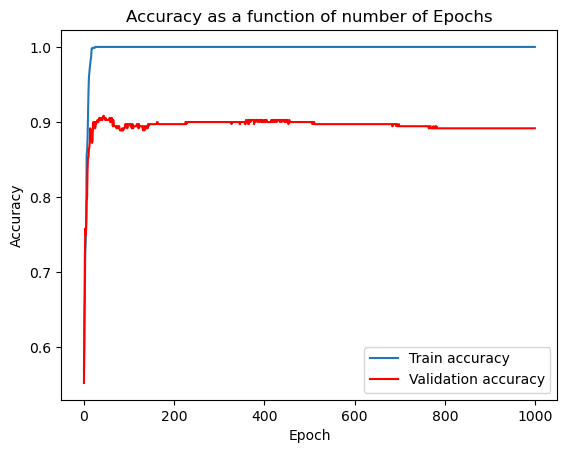

In [48]:
# your code here

eps = [i for i in range(N_eps)]
plt.plot(eps,history.history['accuracy'],label="Train accuracy")
plt.plot(eps,history.history['val_accuracy'],label="Validation accuracy", color='red')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of number of Epochs")
plt.show()

In [49]:
model_overfit.summary()

Model: "model_overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_228 (Dense)           (None, 100)               78500     
                                                                 
 dense_229 (Dense)           (None, 100)               10100     
                                                                 
 dense_230 (Dense)           (None, 100)               10100     
                                                                 
 dense_231 (Dense)           (None, 1)                 101       
                                                                 
Total params: 98,801
Trainable params: 98,801
Non-trainable params: 0
_________________________________________________________________


<div class='exercise-r'>

**2.3.1**  **Regularize the overfit network**

Create an ANN that doesn't overfit and use it to [compete on Kaggle](#part2kaggle).

<a id="q2.3.1"></a>
    
**DON'TS**

- **DO NOT change the architecture**. In other words, keep the same number of layers, same number of nodes, same activation function, and same loss function and output unit as was used in your question 2.2 overfit model. **No CNNs, RNNs, ensembles, or fancy enhancements.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific KMNIST datasets provided to you (via the CS109B [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model (e.g., dropout, L2 norm, etc.).
 - **YOU CAN also** do data augmentation using the provided training data. 
 - **YOU CAN** add flatten layers as you see fit.

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**



</div>

## Data Augmentation

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [51]:
%%time
# your code here

X_train_aug = x_train.copy()
# Reshape the images to 3D tensors
X_train_aug = X_train_aug.values.reshape(-1, 28, 28, 1)

# Define the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,      # rotate the image up to 10 degrees
    width_shift_range=0.1,  # shift the image left or right by up to 10% of the width
    height_shift_range=0.1, # shift the image up or down by up to 10% of the height
    shear_range=0.1,        # apply shearing transformation with maximum of 10%
    zoom_range=0.1,         # zoom in or out by up to 10%
    fill_mode='nearest',    # fill the empty space with the nearest pixel value
    horizontal_flip=True,   # flip the image horizontally
    vertical_flip=True,    # do not flip the image vertically
)

# Fit the ImageDataGenerator on the training data
datagen.fit(X_train_aug)

# Generate augmented images
augmented_images = np.empty((0, 28, 28, 1))
augmented_labels = np.empty((0,))

num_images = 1000

for X_batch, y_batch in datagen.flow(X_train_aug, y_train, batch_size=32):
    augmented_images = np.concatenate((augmented_images, X_batch))
    augmented_labels = np.concatenate((augmented_labels, y_batch))
    if len(augmented_images) >= num_images:
        break

# Convert the labels to integers
augmented_labels = augmented_labels.astype(int)

augmented_images = augmented_images.reshape((augmented_images.shape[0], -1))

X_train_augmented = np.concatenate((x_train, augmented_images))
y_train_augmented = np.concatenate((y_train, augmented_labels))

CPU times: user 375 ms, sys: 52.5 ms, total: 427 ms
Wall time: 432 ms


In [52]:
# your code here
inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(100,activation="relu")(inputs)
x = tf.keras.layers.Dense(100,activation="relu")(x)
x = tf.keras.layers.Dense(100,activation="relu")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

NN_model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model_overfit")
NN_model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])

In [53]:
%%time
N_eps = 700
history=NN_model.fit(X_train_augmented,y_train_augmented,epochs=N_eps,batch_size=128,validation_split=0.3)

Epoch 1/700
13/13 [==============================] - 1s 17ms/step - loss: 12.4576 - accuracy: 0.4788 - val_loss: 3.0152 - val_accuracy: 0.4955
Epoch 2/700
13/13 [==============================] - 0s 6ms/step - loss: 1.7249 - accuracy: 0.5501 - val_loss: 1.0636 - val_accuracy: 0.5539
Epoch 3/700
13/13 [==============================] - 0s 5ms/step - loss: 0.8149 - accuracy: 0.6542 - val_loss: 0.8425 - val_accuracy: 0.5599
Epoch 4/700
13/13 [==============================] - 0s 5ms/step - loss: 0.6306 - accuracy: 0.6870 - val_loss: 0.8078 - val_accuracy: 0.5763
Epoch 5/700
13/13 [==============================] - 0s 5ms/step - loss: 0.5224 - accuracy: 0.7429 - val_loss: 0.8335 - val_accuracy: 0.6078
Epoch 6/700
13/13 [==============================] - 0s 5ms/step - loss: 0.4668 - accuracy: 0.7937 - val_loss: 0.9162 - val_accuracy: 0.6078
Epoch 7/700
13/13 [==============================] - 0s 5ms/step - loss: 0.4334 - accuracy: 0.8123 - val_loss: 0.8130 - val_accuracy: 0.6183
Epoch 8/700

Epoch 59/700
13/13 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.3426 - val_accuracy: 0.7305
Epoch 60/700
13/13 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.3488 - val_accuracy: 0.7320
Epoch 61/700
13/13 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.3783 - val_accuracy: 0.7201
Epoch 62/700
13/13 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.3799 - val_accuracy: 0.7275
Epoch 63/700
13/13 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.4012 - val_accuracy: 0.7275
Epoch 64/700
13/13 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.3951 - val_accuracy: 0.7275
Epoch 65/700
13/13 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.4092 - val_accuracy: 0.7275
Epoch 

Epoch 116/700
13/13 [==============================] - 0s 5ms/step - loss: 4.5740e-04 - accuracy: 1.0000 - val_loss: 1.7602 - val_accuracy: 0.7275
Epoch 117/700
13/13 [==============================] - 0s 5ms/step - loss: 4.3655e-04 - accuracy: 1.0000 - val_loss: 1.7798 - val_accuracy: 0.7275
Epoch 118/700
13/13 [==============================] - 0s 5ms/step - loss: 4.2287e-04 - accuracy: 1.0000 - val_loss: 1.7726 - val_accuracy: 0.7260
Epoch 119/700
13/13 [==============================] - 0s 5ms/step - loss: 4.0598e-04 - accuracy: 1.0000 - val_loss: 1.7726 - val_accuracy: 0.7290
Epoch 120/700
13/13 [==============================] - 0s 5ms/step - loss: 3.9630e-04 - accuracy: 1.0000 - val_loss: 1.7879 - val_accuracy: 0.7246
Epoch 121/700
13/13 [==============================] - 0s 5ms/step - loss: 3.9430e-04 - accuracy: 1.0000 - val_loss: 1.8011 - val_accuracy: 0.7275
Epoch 122/700
13/13 [==============================] - 0s 5ms/step - loss: 3.9366e-04 - accuracy: 1.0000 - val_loss: 1

Epoch 172/700
13/13 [==============================] - 0s 5ms/step - loss: 1.4898e-04 - accuracy: 1.0000 - val_loss: 2.0152 - val_accuracy: 0.7260
Epoch 173/700
13/13 [==============================] - 0s 5ms/step - loss: 1.4603e-04 - accuracy: 1.0000 - val_loss: 2.0243 - val_accuracy: 0.7246
Epoch 174/700
13/13 [==============================] - 0s 5ms/step - loss: 1.4328e-04 - accuracy: 1.0000 - val_loss: 2.0207 - val_accuracy: 0.7246
Epoch 175/700
13/13 [==============================] - 0s 5ms/step - loss: 1.4052e-04 - accuracy: 1.0000 - val_loss: 2.0244 - val_accuracy: 0.7246
Epoch 176/700
13/13 [==============================] - 0s 5ms/step - loss: 1.3817e-04 - accuracy: 1.0000 - val_loss: 2.0305 - val_accuracy: 0.7246
Epoch 177/700
13/13 [==============================] - 0s 5ms/step - loss: 1.3574e-04 - accuracy: 1.0000 - val_loss: 2.0335 - val_accuracy: 0.7246
Epoch 178/700
13/13 [==============================] - 0s 5ms/step - loss: 1.3568e-04 - accuracy: 1.0000 - val_loss: 2

Epoch 228/700
13/13 [==============================] - 0s 6ms/step - loss: 6.4429e-05 - accuracy: 1.0000 - val_loss: 2.2283 - val_accuracy: 0.7246
Epoch 229/700
13/13 [==============================] - 0s 5ms/step - loss: 6.2517e-05 - accuracy: 1.0000 - val_loss: 2.2348 - val_accuracy: 0.7231
Epoch 230/700
13/13 [==============================] - 0s 5ms/step - loss: 6.1661e-05 - accuracy: 1.0000 - val_loss: 2.2357 - val_accuracy: 0.7231
Epoch 231/700
13/13 [==============================] - 0s 5ms/step - loss: 6.0848e-05 - accuracy: 1.0000 - val_loss: 2.2412 - val_accuracy: 0.7231
Epoch 232/700
13/13 [==============================] - 0s 5ms/step - loss: 6.0306e-05 - accuracy: 1.0000 - val_loss: 2.2429 - val_accuracy: 0.7246
Epoch 233/700
13/13 [==============================] - 0s 5ms/step - loss: 5.9949e-05 - accuracy: 1.0000 - val_loss: 2.2485 - val_accuracy: 0.7231
Epoch 234/700
13/13 [==============================] - 0s 5ms/step - loss: 6.2644e-05 - accuracy: 1.0000 - val_loss: 2

Epoch 284/700
13/13 [==============================] - 0s 5ms/step - loss: 3.1355e-05 - accuracy: 1.0000 - val_loss: 2.3977 - val_accuracy: 0.7231
Epoch 285/700
13/13 [==============================] - 0s 5ms/step - loss: 3.0861e-05 - accuracy: 1.0000 - val_loss: 2.3996 - val_accuracy: 0.7231
Epoch 286/700
13/13 [==============================] - 0s 5ms/step - loss: 3.0541e-05 - accuracy: 1.0000 - val_loss: 2.4025 - val_accuracy: 0.7231
Epoch 287/700
13/13 [==============================] - 0s 6ms/step - loss: 3.0159e-05 - accuracy: 1.0000 - val_loss: 2.4054 - val_accuracy: 0.7231
Epoch 288/700
13/13 [==============================] - 0s 5ms/step - loss: 2.9781e-05 - accuracy: 1.0000 - val_loss: 2.4114 - val_accuracy: 0.7231
Epoch 289/700
13/13 [==============================] - 0s 5ms/step - loss: 2.9506e-05 - accuracy: 1.0000 - val_loss: 2.4132 - val_accuracy: 0.7231
Epoch 290/700
13/13 [==============================] - 0s 5ms/step - loss: 2.9354e-05 - accuracy: 1.0000 - val_loss: 2

Epoch 340/700
13/13 [==============================] - 0s 5ms/step - loss: 1.6051e-05 - accuracy: 1.0000 - val_loss: 2.5900 - val_accuracy: 0.7246
Epoch 341/700
13/13 [==============================] - 0s 5ms/step - loss: 1.5949e-05 - accuracy: 1.0000 - val_loss: 2.5913 - val_accuracy: 0.7246
Epoch 342/700
13/13 [==============================] - 0s 5ms/step - loss: 1.5713e-05 - accuracy: 1.0000 - val_loss: 2.5994 - val_accuracy: 0.7246
Epoch 343/700
13/13 [==============================] - 0s 6ms/step - loss: 1.5517e-05 - accuracy: 1.0000 - val_loss: 2.6014 - val_accuracy: 0.7246
Epoch 344/700
13/13 [==============================] - 0s 7ms/step - loss: 1.5319e-05 - accuracy: 1.0000 - val_loss: 2.6084 - val_accuracy: 0.7246
Epoch 345/700
13/13 [==============================] - 0s 5ms/step - loss: 1.5288e-05 - accuracy: 1.0000 - val_loss: 2.6101 - val_accuracy: 0.7246
Epoch 346/700
13/13 [==============================] - 0s 6ms/step - loss: 1.5002e-05 - accuracy: 1.0000 - val_loss: 2

Epoch 396/700
13/13 [==============================] - 0s 5ms/step - loss: 8.7933e-06 - accuracy: 1.0000 - val_loss: 2.7654 - val_accuracy: 0.7260
Epoch 397/700
13/13 [==============================] - 0s 5ms/step - loss: 8.7391e-06 - accuracy: 1.0000 - val_loss: 2.7685 - val_accuracy: 0.7260
Epoch 398/700
13/13 [==============================] - 0s 5ms/step - loss: 8.6975e-06 - accuracy: 1.0000 - val_loss: 2.7701 - val_accuracy: 0.7260
Epoch 399/700
13/13 [==============================] - 0s 5ms/step - loss: 8.5357e-06 - accuracy: 1.0000 - val_loss: 2.7731 - val_accuracy: 0.7260
Epoch 400/700
13/13 [==============================] - 0s 4ms/step - loss: 8.4346e-06 - accuracy: 1.0000 - val_loss: 2.7795 - val_accuracy: 0.7260
Epoch 401/700
13/13 [==============================] - 0s 5ms/step - loss: 8.3512e-06 - accuracy: 1.0000 - val_loss: 2.7833 - val_accuracy: 0.7260
Epoch 402/700
13/13 [==============================] - 0s 5ms/step - loss: 8.2835e-06 - accuracy: 1.0000 - val_loss: 2

Epoch 452/700
13/13 [==============================] - 0s 6ms/step - loss: 5.1077e-06 - accuracy: 1.0000 - val_loss: 2.9285 - val_accuracy: 0.7260
Epoch 453/700
13/13 [==============================] - 0s 5ms/step - loss: 5.0823e-06 - accuracy: 1.0000 - val_loss: 2.9309 - val_accuracy: 0.7260
Epoch 454/700
13/13 [==============================] - 0s 6ms/step - loss: 4.9810e-06 - accuracy: 1.0000 - val_loss: 2.9316 - val_accuracy: 0.7246
Epoch 455/700
13/13 [==============================] - 0s 6ms/step - loss: 4.9181e-06 - accuracy: 1.0000 - val_loss: 2.9373 - val_accuracy: 0.7260
Epoch 456/700
13/13 [==============================] - 0s 5ms/step - loss: 4.9032e-06 - accuracy: 1.0000 - val_loss: 2.9398 - val_accuracy: 0.7260
Epoch 457/700
13/13 [==============================] - 0s 5ms/step - loss: 4.8688e-06 - accuracy: 1.0000 - val_loss: 2.9422 - val_accuracy: 0.7260
Epoch 458/700
13/13 [==============================] - 0s 5ms/step - loss: 4.9284e-06 - accuracy: 1.0000 - val_loss: 2

Epoch 508/700
13/13 [==============================] - 0s 5ms/step - loss: 2.9837e-06 - accuracy: 1.0000 - val_loss: 3.0936 - val_accuracy: 0.7246
Epoch 509/700
13/13 [==============================] - 0s 5ms/step - loss: 2.9808e-06 - accuracy: 1.0000 - val_loss: 3.1004 - val_accuracy: 0.7231
Epoch 510/700
13/13 [==============================] - 0s 5ms/step - loss: 2.9472e-06 - accuracy: 1.0000 - val_loss: 3.1009 - val_accuracy: 0.7246
Epoch 511/700
13/13 [==============================] - 0s 5ms/step - loss: 2.9893e-06 - accuracy: 1.0000 - val_loss: 3.0986 - val_accuracy: 0.7246
Epoch 512/700
13/13 [==============================] - 0s 5ms/step - loss: 2.9137e-06 - accuracy: 1.0000 - val_loss: 3.0947 - val_accuracy: 0.7246
Epoch 513/700
13/13 [==============================] - 0s 5ms/step - loss: 2.8623e-06 - accuracy: 1.0000 - val_loss: 3.1018 - val_accuracy: 0.7246
Epoch 514/700
13/13 [==============================] - 0s 5ms/step - loss: 2.8217e-06 - accuracy: 1.0000 - val_loss: 3

Epoch 564/700
13/13 [==============================] - 0s 5ms/step - loss: 1.7580e-06 - accuracy: 1.0000 - val_loss: 3.2638 - val_accuracy: 0.7231
Epoch 565/700
13/13 [==============================] - 0s 5ms/step - loss: 1.7220e-06 - accuracy: 1.0000 - val_loss: 3.2657 - val_accuracy: 0.7231
Epoch 566/700
13/13 [==============================] - 0s 5ms/step - loss: 1.7104e-06 - accuracy: 1.0000 - val_loss: 3.2700 - val_accuracy: 0.7231
Epoch 567/700
13/13 [==============================] - 0s 5ms/step - loss: 1.6940e-06 - accuracy: 1.0000 - val_loss: 3.2728 - val_accuracy: 0.7231
Epoch 568/700
13/13 [==============================] - 0s 5ms/step - loss: 1.6790e-06 - accuracy: 1.0000 - val_loss: 3.2705 - val_accuracy: 0.7231
Epoch 569/700
13/13 [==============================] - 0s 5ms/step - loss: 1.6657e-06 - accuracy: 1.0000 - val_loss: 3.2795 - val_accuracy: 0.7231
Epoch 570/700
13/13 [==============================] - 0s 5ms/step - loss: 1.6520e-06 - accuracy: 1.0000 - val_loss: 3

Epoch 620/700
13/13 [==============================] - 0s 5ms/step - loss: 1.0137e-06 - accuracy: 1.0000 - val_loss: 3.4199 - val_accuracy: 0.7246
Epoch 621/700
13/13 [==============================] - 0s 5ms/step - loss: 1.0077e-06 - accuracy: 1.0000 - val_loss: 3.4238 - val_accuracy: 0.7246
Epoch 622/700
13/13 [==============================] - 0s 5ms/step - loss: 9.9896e-07 - accuracy: 1.0000 - val_loss: 3.4288 - val_accuracy: 0.7246
Epoch 623/700
13/13 [==============================] - 0s 5ms/step - loss: 9.8808e-07 - accuracy: 1.0000 - val_loss: 3.4278 - val_accuracy: 0.7246
Epoch 624/700
13/13 [==============================] - 0s 5ms/step - loss: 9.7861e-07 - accuracy: 1.0000 - val_loss: 3.4316 - val_accuracy: 0.7246
Epoch 625/700
13/13 [==============================] - 0s 5ms/step - loss: 9.7868e-07 - accuracy: 1.0000 - val_loss: 3.4341 - val_accuracy: 0.7246
Epoch 626/700
13/13 [==============================] - 0s 5ms/step - loss: 9.6333e-07 - accuracy: 1.0000 - val_loss: 3

Epoch 676/700
13/13 [==============================] - 0s 5ms/step - loss: 6.3134e-07 - accuracy: 1.0000 - val_loss: 3.5497 - val_accuracy: 0.7246
Epoch 677/700
13/13 [==============================] - 0s 5ms/step - loss: 6.2000e-07 - accuracy: 1.0000 - val_loss: 3.5545 - val_accuracy: 0.7231
Epoch 678/700
13/13 [==============================] - 0s 5ms/step - loss: 6.1422e-07 - accuracy: 1.0000 - val_loss: 3.5560 - val_accuracy: 0.7246
Epoch 679/700
13/13 [==============================] - 0s 5ms/step - loss: 6.2403e-07 - accuracy: 1.0000 - val_loss: 3.5554 - val_accuracy: 0.7246
Epoch 680/700
13/13 [==============================] - 0s 5ms/step - loss: 6.1386e-07 - accuracy: 1.0000 - val_loss: 3.5643 - val_accuracy: 0.7231
Epoch 681/700
13/13 [==============================] - 0s 5ms/step - loss: 5.9722e-07 - accuracy: 1.0000 - val_loss: 3.5598 - val_accuracy: 0.7260
Epoch 682/700
13/13 [==============================] - 0s 5ms/step - loss: 5.9671e-07 - accuracy: 1.0000 - val_loss: 3

## Regularization

In [54]:
%%time 
# your code here
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=75, 
                                            restore_best_weights=True, 
                                            verbose=1)

Cs = [10**i for i in range(-4,2)]
val_accs_l2 = []
for l in Cs:
    
    l_reg = tf.keras.regularizers.L2(l)
    
    inputs = tf.keras.layers.Input(shape=(784,))
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
    history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
    val_accs_l2.append(max(history.history['val_accuracy']))


Epoch 1/300
7/7 [==============================] - 1s 33ms/step - loss: 4.8676 - accuracy: 0.5405 - val_loss: 1.9302 - val_accuracy: 0.5917
Epoch 2/300
7/7 [==============================] - 0s 8ms/step - loss: 1.7197 - accuracy: 0.6893 - val_loss: 1.2249 - val_accuracy: 0.7250
Epoch 3/300
7/7 [==============================] - 0s 9ms/step - loss: 0.9710 - accuracy: 0.7786 - val_loss: 1.2102 - val_accuracy: 0.6667
Epoch 4/300
7/7 [==============================] - 0s 10ms/step - loss: 0.7360 - accuracy: 0.7833 - val_loss: 0.7875 - val_accuracy: 0.7944
Epoch 5/300
7/7 [==============================] - 0s 9ms/step - loss: 0.5640 - accuracy: 0.8393 - val_loss: 0.7194 - val_accuracy: 0.8000
Epoch 6/300
7/7 [==============================] - 0s 9ms/step - loss: 0.3582 - accuracy: 0.8810 - val_loss: 0.6309 - val_accuracy: 0.8417
Epoch 7/300
7/7 [==============================] - 0s 8ms/step - loss: 0.3069 - accuracy: 0.8988 - val_loss: 0.5487 - val_accuracy: 0.8250
Epoch 8/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.0332 - accuracy: 1.0000 - val_loss: 0.6114 - val_accuracy: 0.8806
Epoch 60/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.6036 - val_accuracy: 0.8750
Epoch 61/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.6122 - val_accuracy: 0.8778
Epoch 62/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.6102 - val_accuracy: 0.8722
Epoch 63/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.6199 - val_accuracy: 0.8778
Epoch 64/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.6172 - val_accuracy: 0.8722
Epoch 65/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.6242 - val_accuracy: 0.8778
Epoch 66/300
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 0.3126 - accuracy: 1.0000 - val_loss: 0.6022 - val_accuracy: 0.9111
Epoch 32/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3108 - accuracy: 1.0000 - val_loss: 0.6040 - val_accuracy: 0.9111
Epoch 33/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3094 - accuracy: 1.0000 - val_loss: 0.6034 - val_accuracy: 0.9083
Epoch 34/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3077 - accuracy: 1.0000 - val_loss: 0.6021 - val_accuracy: 0.9167
Epoch 35/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3063 - accuracy: 1.0000 - val_loss: 0.6038 - val_accuracy: 0.9139
Epoch 36/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3049 - accuracy: 1.0000 - val_loss: 0.6043 - val_accuracy: 0.9139
Epoch 37/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3036 - accuracy: 1.0000 - val_loss: 0.6055 - val_accuracy: 0.9194
Epoch 38/300
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 0.2561 - accuracy: 1.0000 - val_loss: 0.6379 - val_accuracy: 0.9222
Epoch 90/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2554 - accuracy: 1.0000 - val_loss: 0.6382 - val_accuracy: 0.9278
Epoch 91/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2546 - accuracy: 1.0000 - val_loss: 0.6378 - val_accuracy: 0.9250
Epoch 92/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2539 - accuracy: 1.0000 - val_loss: 0.6391 - val_accuracy: 0.9222
Epoch 93/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2531 - accuracy: 1.0000 - val_loss: 0.6354 - val_accuracy: 0.9306
Epoch 94/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2524 - accuracy: 1.0000 - val_loss: 0.6358 - val_accuracy: 0.9222
Epoch 95/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2517 - accuracy: 1.0000 - val_loss: 0.6353 - val_accuracy: 0.9222
Epoch 96/300
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 2.2894 - accuracy: 1.0000 - val_loss: 2.6253 - val_accuracy: 0.8944
Epoch 44/300
7/7 [==============================] - 0s 7ms/step - loss: 2.2706 - accuracy: 1.0000 - val_loss: 2.6094 - val_accuracy: 0.8944
Epoch 45/300
7/7 [==============================] - 0s 7ms/step - loss: 2.2520 - accuracy: 1.0000 - val_loss: 2.5851 - val_accuracy: 0.8944
Epoch 46/300
7/7 [==============================] - 0s 7ms/step - loss: 2.2334 - accuracy: 1.0000 - val_loss: 2.5675 - val_accuracy: 0.8917
Epoch 47/300
7/7 [==============================] - 0s 7ms/step - loss: 2.2152 - accuracy: 1.0000 - val_loss: 2.5500 - val_accuracy: 0.8944
Epoch 48/300
7/7 [==============================] - 0s 7ms/step - loss: 2.1971 - accuracy: 1.0000 - val_loss: 2.5317 - val_accuracy: 0.8944
Epoch 49/300
7/7 [==============================] - 0s 7ms/step - loss: 2.1792 - accuracy: 1.0000 - val_loss: 2.5108 - val_accuracy: 0.8889
Epoch 50/300
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 1.4453 - accuracy: 1.0000 - val_loss: 1.7673 - val_accuracy: 0.9167
Epoch 102/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4340 - accuracy: 1.0000 - val_loss: 1.7553 - val_accuracy: 0.9222
Epoch 103/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4231 - accuracy: 1.0000 - val_loss: 1.7475 - val_accuracy: 0.9111
Epoch 104/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4123 - accuracy: 1.0000 - val_loss: 1.7332 - val_accuracy: 0.9167
Epoch 105/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4015 - accuracy: 1.0000 - val_loss: 1.7218 - val_accuracy: 0.9167
Epoch 106/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3908 - accuracy: 1.0000 - val_loss: 1.7100 - val_accuracy: 0.9194
Epoch 107/300
7/7 [==============================] - 0s 7ms/step - loss: 1.3802 - accuracy: 1.0000 - val_loss: 1.7003 - val_accuracy: 0.9194
Epoch 108/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.9350 - accuracy: 1.0000 - val_loss: 1.2409 - val_accuracy: 0.9306
Epoch 160/300
7/7 [==============================] - 0s 7ms/step - loss: 0.9281 - accuracy: 1.0000 - val_loss: 1.2352 - val_accuracy: 0.9306
Epoch 161/300
7/7 [==============================] - 0s 7ms/step - loss: 0.9212 - accuracy: 1.0000 - val_loss: 1.2339 - val_accuracy: 0.9250
Epoch 162/300
7/7 [==============================] - 0s 6ms/step - loss: 0.9146 - accuracy: 1.0000 - val_loss: 1.2270 - val_accuracy: 0.9250
Epoch 163/300
7/7 [==============================] - 0s 6ms/step - loss: 0.9078 - accuracy: 1.0000 - val_loss: 1.2178 - val_accuracy: 0.9306
Epoch 164/300
7/7 [==============================] - 0s 7ms/step - loss: 0.9011 - accuracy: 1.0000 - val_loss: 1.2130 - val_accuracy: 0.9250
Epoch 165/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8946 - accuracy: 1.0000 - val_loss: 1.2056 - val_accuracy: 0.9278
Epoch 166/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.6876 - accuracy: 1.0000 - val_loss: 0.9555 - val_accuracy: 0.9250
Epoch 218/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6828 - accuracy: 1.0000 - val_loss: 0.9557 - val_accuracy: 0.9306
Epoch 219/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6782 - accuracy: 1.0000 - val_loss: 0.9506 - val_accuracy: 0.9278
Epoch 220/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6735 - accuracy: 1.0000 - val_loss: 0.9498 - val_accuracy: 0.9278
Epoch 221/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6689 - accuracy: 1.0000 - val_loss: 0.9460 - val_accuracy: 0.9250
Epoch 222/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6644 - accuracy: 1.0000 - val_loss: 0.9430 - val_accuracy: 0.9250
Epoch 223/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6599 - accuracy: 1.0000 - val_loss: 0.9391 - val_accuracy: 0.9250
Epoch 224/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.4660 - accuracy: 1.0000 - val_loss: 0.8045 - val_accuracy: 0.9222
Epoch 276/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4629 - accuracy: 1.0000 - val_loss: 0.8027 - val_accuracy: 0.9222
Epoch 277/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4599 - accuracy: 1.0000 - val_loss: 0.8031 - val_accuracy: 0.9306
Epoch 278/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4569 - accuracy: 1.0000 - val_loss: 0.7971 - val_accuracy: 0.9250
Epoch 279/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4538 - accuracy: 1.0000 - val_loss: 0.7952 - val_accuracy: 0.9222
Epoch 280/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4508 - accuracy: 1.0000 - val_loss: 0.8025 - val_accuracy: 0.9333
Epoch 281/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4480 - accuracy: 1.0000 - val_loss: 0.7923 - val_accuracy: 0.9222
Epoch 282/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 14.2255 - accuracy: 1.0000 - val_loss: 14.2436 - val_accuracy: 0.8944
Epoch 34/300
7/7 [==============================] - 0s 7ms/step - loss: 13.8707 - accuracy: 1.0000 - val_loss: 13.8940 - val_accuracy: 0.8972
Epoch 35/300
7/7 [==============================] - 0s 7ms/step - loss: 13.5278 - accuracy: 1.0000 - val_loss: 13.5522 - val_accuracy: 0.8972
Epoch 36/300
7/7 [==============================] - 0s 6ms/step - loss: 13.1938 - accuracy: 1.0000 - val_loss: 13.2265 - val_accuracy: 0.8972
Epoch 37/300
7/7 [==============================] - 0s 6ms/step - loss: 12.8716 - accuracy: 1.0000 - val_loss: 12.9093 - val_accuracy: 0.8944
Epoch 38/300
7/7 [==============================] - 0s 7ms/step - loss: 12.5573 - accuracy: 1.0000 - val_loss: 12.5874 - val_accuracy: 0.9000
Epoch 39/300
7/7 [==============================] - 0s 6ms/step - loss: 12.2505 - accuracy: 1.0000 - val_loss: 12.2861 - val_accuracy: 0.9111
Epoch 40/300
7/7 [=

7/7 [==============================] - 0s 7ms/step - loss: 3.8334 - accuracy: 1.0000 - val_loss: 3.9419 - val_accuracy: 0.9417
Epoch 92/300
7/7 [==============================] - 0s 7ms/step - loss: 3.7557 - accuracy: 1.0000 - val_loss: 3.8594 - val_accuracy: 0.9361
Epoch 93/300
7/7 [==============================] - 0s 7ms/step - loss: 3.6810 - accuracy: 1.0000 - val_loss: 3.7911 - val_accuracy: 0.9333
Epoch 94/300
7/7 [==============================] - 0s 7ms/step - loss: 3.6091 - accuracy: 1.0000 - val_loss: 3.7221 - val_accuracy: 0.9444
Epoch 95/300
7/7 [==============================] - 0s 6ms/step - loss: 3.5372 - accuracy: 1.0000 - val_loss: 3.6440 - val_accuracy: 0.9444
Epoch 96/300
7/7 [==============================] - 0s 7ms/step - loss: 3.4681 - accuracy: 1.0000 - val_loss: 3.5755 - val_accuracy: 0.9444
Epoch 97/300
7/7 [==============================] - 0s 7ms/step - loss: 3.4025 - accuracy: 1.0000 - val_loss: 3.5170 - val_accuracy: 0.9444
Epoch 98/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 1.4902 - accuracy: 1.0000 - val_loss: 1.6199 - val_accuracy: 0.9417
Epoch 150/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4685 - accuracy: 1.0000 - val_loss: 1.5982 - val_accuracy: 0.9417
Epoch 151/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4472 - accuracy: 1.0000 - val_loss: 1.5769 - val_accuracy: 0.9417
Epoch 152/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4260 - accuracy: 1.0000 - val_loss: 1.5580 - val_accuracy: 0.9444
Epoch 153/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4057 - accuracy: 1.0000 - val_loss: 1.5364 - val_accuracy: 0.9389
Epoch 154/300
7/7 [==============================] - 0s 7ms/step - loss: 1.3852 - accuracy: 1.0000 - val_loss: 1.5169 - val_accuracy: 0.9417
Epoch 155/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3652 - accuracy: 1.0000 - val_loss: 1.4995 - val_accuracy: 0.9389
Epoch 156/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 1.0390 - accuracy: 0.9643 - val_loss: 1.0182 - val_accuracy: 0.9583
Epoch 208/300
7/7 [==============================] - 0s 6ms/step - loss: 1.0165 - accuracy: 0.9536 - val_loss: 1.1645 - val_accuracy: 0.9028
Epoch 209/300
7/7 [==============================] - 0s 6ms/step - loss: 0.9996 - accuracy: 0.9583 - val_loss: 0.9813 - val_accuracy: 0.9556
Epoch 210/300
7/7 [==============================] - 0s 6ms/step - loss: 0.9502 - accuracy: 0.9690 - val_loss: 0.9719 - val_accuracy: 0.9472
Epoch 211/300
7/7 [==============================] - 0s 6ms/step - loss: 0.9004 - accuracy: 0.9798 - val_loss: 0.9495 - val_accuracy: 0.9583
Epoch 212/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8765 - accuracy: 0.9845 - val_loss: 0.9399 - val_accuracy: 0.9583
Epoch 213/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8432 - accuracy: 0.9929 - val_loss: 0.9254 - val_accuracy: 0.9500
Epoch 214/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.4103 - accuracy: 1.0000 - val_loss: 0.5465 - val_accuracy: 0.9472
Epoch 266/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4090 - accuracy: 1.0000 - val_loss: 0.5432 - val_accuracy: 0.9472
Epoch 267/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4018 - accuracy: 1.0000 - val_loss: 0.5437 - val_accuracy: 0.9417
Epoch 268/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3969 - accuracy: 1.0000 - val_loss: 0.5438 - val_accuracy: 0.9361
Epoch 269/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3939 - accuracy: 1.0000 - val_loss: 0.5298 - val_accuracy: 0.9472
Epoch 270/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3878 - accuracy: 1.0000 - val_loss: 0.5298 - val_accuracy: 0.9472
Epoch 271/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3841 - accuracy: 1.0000 - val_loss: 0.5326 - val_accuracy: 0.9333
Epoch 272/300
7/7 [========

Epoch 23/300
7/7 [==============================] - 0s 7ms/step - loss: 39.8981 - accuracy: 0.9631 - val_loss: 37.9241 - val_accuracy: 0.9167
Epoch 24/300
7/7 [==============================] - 0s 7ms/step - loss: 36.5843 - accuracy: 0.9619 - val_loss: 34.8184 - val_accuracy: 0.9139
Epoch 25/300
7/7 [==============================] - 0s 7ms/step - loss: 33.5967 - accuracy: 0.9619 - val_loss: 32.0036 - val_accuracy: 0.9278
Epoch 26/300
7/7 [==============================] - 0s 7ms/step - loss: 30.8831 - accuracy: 0.9702 - val_loss: 29.4734 - val_accuracy: 0.9250
Epoch 27/300
7/7 [==============================] - 0s 7ms/step - loss: 28.4573 - accuracy: 0.9786 - val_loss: 27.1937 - val_accuracy: 0.9250
Epoch 28/300
7/7 [==============================] - 0s 7ms/step - loss: 26.2735 - accuracy: 0.9690 - val_loss: 25.1426 - val_accuracy: 0.9167
Epoch 29/300
7/7 [==============================] - 0s 7ms/step - loss: 24.3109 - accuracy: 0.9667 - val_loss: 23.3158 - val_accuracy: 0.8972
Epoch 

7/7 [==============================] - 0s 7ms/step - loss: 1.7800 - accuracy: 0.9750 - val_loss: 1.7822 - val_accuracy: 0.9556
Epoch 82/300
7/7 [==============================] - 0s 7ms/step - loss: 1.7173 - accuracy: 0.9821 - val_loss: 1.7408 - val_accuracy: 0.9361
Epoch 83/300
7/7 [==============================] - 0s 7ms/step - loss: 1.6649 - accuracy: 0.9774 - val_loss: 1.6839 - val_accuracy: 0.9500
Epoch 84/300
7/7 [==============================] - 0s 7ms/step - loss: 1.6055 - accuracy: 0.9786 - val_loss: 1.6129 - val_accuracy: 0.9556
Epoch 85/300
7/7 [==============================] - 0s 6ms/step - loss: 1.5507 - accuracy: 0.9798 - val_loss: 1.5608 - val_accuracy: 0.9556
Epoch 86/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4932 - accuracy: 0.9833 - val_loss: 1.5159 - val_accuracy: 0.9528
Epoch 87/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4472 - accuracy: 0.9810 - val_loss: 1.4894 - val_accuracy: 0.9306
Epoch 88/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.4619 - accuracy: 0.9893 - val_loss: 0.5247 - val_accuracy: 0.9500
Epoch 140/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4613 - accuracy: 0.9869 - val_loss: 0.5102 - val_accuracy: 0.9500
Epoch 141/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4505 - accuracy: 0.9869 - val_loss: 0.5171 - val_accuracy: 0.9444
Epoch 142/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4461 - accuracy: 0.9905 - val_loss: 0.5105 - val_accuracy: 0.9500
Epoch 143/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4443 - accuracy: 0.9869 - val_loss: 0.4982 - val_accuracy: 0.9472
Epoch 144/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4458 - accuracy: 0.9893 - val_loss: 0.4975 - val_accuracy: 0.9500
Epoch 145/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4304 - accuracy: 0.9905 - val_loss: 0.5042 - val_accuracy: 0.9500
Epoch 146/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.3671 - accuracy: 0.9679 - val_loss: 0.4324 - val_accuracy: 0.9333
Epoch 198/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3367 - accuracy: 0.9786 - val_loss: 0.3799 - val_accuracy: 0.9556
Epoch 199/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3242 - accuracy: 0.9869 - val_loss: 0.3797 - val_accuracy: 0.9556
Epoch 200/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3196 - accuracy: 0.9893 - val_loss: 0.3811 - val_accuracy: 0.9583
Epoch 201/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3183 - accuracy: 0.9857 - val_loss: 0.3872 - val_accuracy: 0.9389
Epoch 202/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3228 - accuracy: 0.9869 - val_loss: 0.4417 - val_accuracy: 0.9278
Epoch 203/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3488 - accuracy: 0.9702 - val_loss: 0.4128 - val_accuracy: 0.9250
Epoch 204/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.2955 - accuracy: 0.9845 - val_loss: 0.3867 - val_accuracy: 0.9389
Epoch 256/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3009 - accuracy: 0.9798 - val_loss: 0.3783 - val_accuracy: 0.9333
Epoch 257/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2895 - accuracy: 0.9893 - val_loss: 0.3549 - val_accuracy: 0.9556
Epoch 258/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2768 - accuracy: 0.9929 - val_loss: 0.3510 - val_accuracy: 0.9528
Epoch 259/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2747 - accuracy: 0.9952 - val_loss: 0.3528 - val_accuracy: 0.9556
Epoch 260/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2810 - accuracy: 0.9893 - val_loss: 0.3541 - val_accuracy: 0.9472
Epoch 261/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2827 - accuracy: 0.9905 - val_loss: 0.3570 - val_accuracy: 0.9500
Epoch 262/300
7/7 [========

Epoch 13/300
7/7 [==============================] - 0s 7ms/step - loss: 392.3622 - accuracy: 0.8595 - val_loss: 354.4736 - val_accuracy: 0.9222
Epoch 14/300
7/7 [==============================] - 0s 7ms/step - loss: 331.9965 - accuracy: 0.8917 - val_loss: 300.2358 - val_accuracy: 0.8833
Epoch 15/300
7/7 [==============================] - 0s 7ms/step - loss: 281.3094 - accuracy: 0.9226 - val_loss: 254.5462 - val_accuracy: 0.9389
Epoch 16/300
7/7 [==============================] - 0s 6ms/step - loss: 238.5477 - accuracy: 0.9321 - val_loss: 215.8907 - val_accuracy: 0.9444
Epoch 17/300
7/7 [==============================] - 0s 6ms/step - loss: 202.3180 - accuracy: 0.9417 - val_loss: 183.0733 - val_accuracy: 0.9472
Epoch 18/300
7/7 [==============================] - 0s 6ms/step - loss: 171.5400 - accuracy: 0.9167 - val_loss: 155.1611 - val_accuracy: 0.9500
Epoch 19/300
7/7 [==============================] - 0s 7ms/step - loss: 145.3136 - accuracy: 0.9333 - val_loss: 131.3544 - val_accuracy:

7/7 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5250 - val_loss: 0.6942 - val_accuracy: 0.4944
Epoch 72/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5250 - val_loss: 0.6941 - val_accuracy: 0.4944
Epoch 73/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.5250 - val_loss: 0.6940 - val_accuracy: 0.4944
Epoch 74/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5250 - val_loss: 0.6938 - val_accuracy: 0.4944
Epoch 75/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5250 - val_loss: 0.6938 - val_accuracy: 0.4944
Epoch 76/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5250 - val_loss: 0.6938 - val_accuracy: 0.4944
Epoch 77/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5250 - val_loss: 0.6937 - val_accuracy: 0.4944
Epoch 78/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6946 - val_accuracy: 0.4944
Epoch 130/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5250 - val_loss: 0.6946 - val_accuracy: 0.4944
Epoch 131/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6946 - val_accuracy: 0.4944
Epoch 132/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5250 - val_loss: 0.6946 - val_accuracy: 0.4944
Epoch 133/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5250 - val_loss: 0.6947 - val_accuracy: 0.4944
Epoch 134/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6947 - val_accuracy: 0.4944
Epoch 135/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6947 - val_accuracy: 0.4944
Epoch 136/300
7/7 [========

In [55]:
val_accs_l1 = []
for l in Cs:
    l_reg = tf.keras.regularizers.L1(l)
    
    inputs = tf.keras.layers.Input(shape=(784,))
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy',metrics=["accuracy"])
    history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
    val_accs_l1.append(max(history.history['val_accuracy']))

Epoch 1/300
7/7 [==============================] - 1s 31ms/step - loss: 11.1358 - accuracy: 0.5226 - val_loss: 6.5816 - val_accuracy: 0.5028
Epoch 2/300
7/7 [==============================] - 0s 8ms/step - loss: 4.6910 - accuracy: 0.5012 - val_loss: 2.4886 - val_accuracy: 0.5667
Epoch 3/300
7/7 [==============================] - 0s 8ms/step - loss: 2.4302 - accuracy: 0.5845 - val_loss: 1.4816 - val_accuracy: 0.7250
Epoch 4/300
7/7 [==============================] - 0s 7ms/step - loss: 1.5763 - accuracy: 0.7048 - val_loss: 1.4153 - val_accuracy: 0.7167
Epoch 5/300
7/7 [==============================] - 0s 8ms/step - loss: 1.1328 - accuracy: 0.7762 - val_loss: 1.2716 - val_accuracy: 0.7389
Epoch 6/300
7/7 [==============================] - 0s 7ms/step - loss: 0.9556 - accuracy: 0.8214 - val_loss: 1.1557 - val_accuracy: 0.7639
Epoch 7/300
7/7 [==============================] - 0s 8ms/step - loss: 0.9073 - accuracy: 0.8238 - val_loss: 1.0495 - val_accuracy: 0.8167
Epoch 8/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.4255 - accuracy: 1.0000 - val_loss: 0.8285 - val_accuracy: 0.8972
Epoch 60/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4246 - accuracy: 1.0000 - val_loss: 0.8358 - val_accuracy: 0.8972
Epoch 61/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4237 - accuracy: 1.0000 - val_loss: 0.8353 - val_accuracy: 0.8944
Epoch 62/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4228 - accuracy: 1.0000 - val_loss: 0.8299 - val_accuracy: 0.8972
Epoch 63/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4220 - accuracy: 1.0000 - val_loss: 0.8415 - val_accuracy: 0.8944
Epoch 64/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4212 - accuracy: 1.0000 - val_loss: 0.8247 - val_accuracy: 0.8972
Epoch 65/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4203 - accuracy: 1.0000 - val_loss: 0.8387 - val_accuracy: 0.8972
Epoch 66/300
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 0.3806 - accuracy: 1.0000 - val_loss: 0.8059 - val_accuracy: 0.9028
Epoch 118/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3799 - accuracy: 1.0000 - val_loss: 0.8051 - val_accuracy: 0.9028
Epoch 119/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3792 - accuracy: 1.0000 - val_loss: 0.8021 - val_accuracy: 0.9056
Epoch 120/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3786 - accuracy: 1.0000 - val_loss: 0.8051 - val_accuracy: 0.9000
Epoch 121/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3779 - accuracy: 1.0000 - val_loss: 0.8028 - val_accuracy: 0.9028
Epoch 122/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3772 - accuracy: 1.0000 - val_loss: 0.7998 - val_accuracy: 0.9056
Epoch 123/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3765 - accuracy: 1.0000 - val_loss: 0.8048 - val_accuracy: 0.9028
Epoch 124/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.3433 - accuracy: 1.0000 - val_loss: 0.7440 - val_accuracy: 0.9056
Epoch 176/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3427 - accuracy: 1.0000 - val_loss: 0.7473 - val_accuracy: 0.9083
Epoch 177/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3421 - accuracy: 1.0000 - val_loss: 0.7429 - val_accuracy: 0.9083
Epoch 178/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3415 - accuracy: 1.0000 - val_loss: 0.7469 - val_accuracy: 0.9083
Epoch 179/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3409 - accuracy: 1.0000 - val_loss: 0.7390 - val_accuracy: 0.9056
Epoch 180/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3403 - accuracy: 1.0000 - val_loss: 0.7423 - val_accuracy: 0.9083
Epoch 181/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3397 - accuracy: 1.0000 - val_loss: 0.7402 - val_accuracy: 0.9083
Epoch 182/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.3100 - accuracy: 1.0000 - val_loss: 0.6997 - val_accuracy: 0.9194
Epoch 234/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3095 - accuracy: 1.0000 - val_loss: 0.7031 - val_accuracy: 0.9222
Epoch 235/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3089 - accuracy: 1.0000 - val_loss: 0.7017 - val_accuracy: 0.9222
Epoch 236/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3084 - accuracy: 1.0000 - val_loss: 0.7007 - val_accuracy: 0.9222
Epoch 237/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3078 - accuracy: 1.0000 - val_loss: 0.6956 - val_accuracy: 0.9222
Epoch 238/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3073 - accuracy: 1.0000 - val_loss: 0.7106 - val_accuracy: 0.9306
Epoch 239/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3067 - accuracy: 1.0000 - val_loss: 0.6972 - val_accuracy: 0.9222
Epoch 240/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.2787 - accuracy: 1.0000 - val_loss: 0.6837 - val_accuracy: 0.9250
Epoch 292/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2782 - accuracy: 1.0000 - val_loss: 0.6779 - val_accuracy: 0.9250
Epoch 293/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2777 - accuracy: 1.0000 - val_loss: 0.6692 - val_accuracy: 0.9250
Epoch 294/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2771 - accuracy: 1.0000 - val_loss: 0.6763 - val_accuracy: 0.9278
Epoch 295/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2766 - accuracy: 1.0000 - val_loss: 0.6682 - val_accuracy: 0.9250
Epoch 296/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2761 - accuracy: 1.0000 - val_loss: 0.6725 - val_accuracy: 0.9278
Epoch 297/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2756 - accuracy: 1.0000 - val_loss: 0.6846 - val_accuracy: 0.9250
Epoch 298/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 3.3453 - accuracy: 1.0000 - val_loss: 3.7420 - val_accuracy: 0.8861
Epoch 50/300
7/7 [==============================] - 0s 7ms/step - loss: 3.3232 - accuracy: 1.0000 - val_loss: 3.7249 - val_accuracy: 0.8861
Epoch 51/300
7/7 [==============================] - 0s 7ms/step - loss: 3.3013 - accuracy: 1.0000 - val_loss: 3.7022 - val_accuracy: 0.8889
Epoch 52/300
7/7 [==============================] - 0s 7ms/step - loss: 3.2798 - accuracy: 1.0000 - val_loss: 3.6834 - val_accuracy: 0.8889
Epoch 53/300
7/7 [==============================] - 0s 7ms/step - loss: 3.2583 - accuracy: 1.0000 - val_loss: 3.6627 - val_accuracy: 0.8917
Epoch 54/300
7/7 [==============================] - 0s 7ms/step - loss: 3.2370 - accuracy: 1.0000 - val_loss: 3.6405 - val_accuracy: 0.8917
Epoch 55/300
7/7 [==============================] - 0s 7ms/step - loss: 3.2160 - accuracy: 1.0000 - val_loss: 3.6229 - val_accuracy: 0.8944
Epoch 56/300
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 2.2948 - accuracy: 1.0000 - val_loss: 2.6755 - val_accuracy: 0.9000
Epoch 108/300
7/7 [==============================] - 0s 7ms/step - loss: 2.2800 - accuracy: 1.0000 - val_loss: 2.6558 - val_accuracy: 0.9056
Epoch 109/300
7/7 [==============================] - 0s 7ms/step - loss: 2.2653 - accuracy: 1.0000 - val_loss: 2.6425 - val_accuracy: 0.9028
Epoch 110/300
7/7 [==============================] - 0s 7ms/step - loss: 2.2507 - accuracy: 1.0000 - val_loss: 2.6249 - val_accuracy: 0.9056
Epoch 111/300
7/7 [==============================] - 0s 7ms/step - loss: 2.2362 - accuracy: 1.0000 - val_loss: 2.6098 - val_accuracy: 0.9083
Epoch 112/300
7/7 [==============================] - 0s 7ms/step - loss: 2.2218 - accuracy: 1.0000 - val_loss: 2.5947 - val_accuracy: 0.9028
Epoch 113/300
7/7 [==============================] - 0s 7ms/step - loss: 2.2074 - accuracy: 1.0000 - val_loss: 2.5843 - val_accuracy: 0.9000
Epoch 114/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 2.1201 - accuracy: 0.8440 - val_loss: 2.1781 - val_accuracy: 0.8000
Epoch 166/300
7/7 [==============================] - 0s 7ms/step - loss: 1.9606 - accuracy: 0.9012 - val_loss: 2.1306 - val_accuracy: 0.8472
Epoch 167/300
7/7 [==============================] - 0s 7ms/step - loss: 1.9831 - accuracy: 0.8952 - val_loss: 2.0718 - val_accuracy: 0.8778
Epoch 168/300
7/7 [==============================] - 0s 7ms/step - loss: 1.8140 - accuracy: 0.9655 - val_loss: 2.0368 - val_accuracy: 0.9139
Epoch 169/300
7/7 [==============================] - 0s 7ms/step - loss: 1.8028 - accuracy: 0.9690 - val_loss: 1.9977 - val_accuracy: 0.9222
Epoch 170/300
7/7 [==============================] - 0s 7ms/step - loss: 1.7608 - accuracy: 0.9774 - val_loss: 1.9498 - val_accuracy: 0.9056
Epoch 171/300
7/7 [==============================] - 0s 7ms/step - loss: 1.7123 - accuracy: 0.9881 - val_loss: 1.9228 - val_accuracy: 0.9167
Epoch 172/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 1.1470 - accuracy: 1.0000 - val_loss: 1.4599 - val_accuracy: 0.9167
Epoch 224/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1394 - accuracy: 1.0000 - val_loss: 1.4527 - val_accuracy: 0.9167
Epoch 225/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1319 - accuracy: 1.0000 - val_loss: 1.4454 - val_accuracy: 0.9194
Epoch 226/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1246 - accuracy: 1.0000 - val_loss: 1.4385 - val_accuracy: 0.9194
Epoch 227/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1171 - accuracy: 1.0000 - val_loss: 1.4316 - val_accuracy: 0.9222
Epoch 228/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1097 - accuracy: 1.0000 - val_loss: 1.4229 - val_accuracy: 0.9194
Epoch 229/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1023 - accuracy: 1.0000 - val_loss: 1.4158 - val_accuracy: 0.9167
Epoch 230/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.7822 - accuracy: 1.0000 - val_loss: 1.0978 - val_accuracy: 0.9250
Epoch 282/300
7/7 [==============================] - 0s 7ms/step - loss: 0.7770 - accuracy: 1.0000 - val_loss: 1.0924 - val_accuracy: 0.9278
Epoch 283/300
7/7 [==============================] - 0s 7ms/step - loss: 0.7719 - accuracy: 1.0000 - val_loss: 1.0872 - val_accuracy: 0.9278
Epoch 284/300
7/7 [==============================] - 0s 7ms/step - loss: 0.7669 - accuracy: 1.0000 - val_loss: 1.0820 - val_accuracy: 0.9278
Epoch 285/300
7/7 [==============================] - 0s 7ms/step - loss: 0.7618 - accuracy: 1.0000 - val_loss: 1.0764 - val_accuracy: 0.9250
Epoch 286/300
7/7 [==============================] - 0s 7ms/step - loss: 0.7568 - accuracy: 1.0000 - val_loss: 1.0709 - val_accuracy: 0.9278
Epoch 287/300
7/7 [==============================] - 0s 7ms/step - loss: 0.7519 - accuracy: 1.0000 - val_loss: 1.0657 - val_accuracy: 0.9278
Epoch 288/300
7/7 [========

Epoch 39/300
7/7 [==============================] - 0s 7ms/step - loss: 14.8199 - accuracy: 0.9988 - val_loss: 14.8000 - val_accuracy: 0.9139
Epoch 40/300
7/7 [==============================] - 0s 7ms/step - loss: 14.4296 - accuracy: 0.9988 - val_loss: 14.3938 - val_accuracy: 0.9056
Epoch 41/300
7/7 [==============================] - 0s 7ms/step - loss: 14.0471 - accuracy: 1.0000 - val_loss: 14.0240 - val_accuracy: 0.9111
Epoch 42/300
7/7 [==============================] - 0s 7ms/step - loss: 13.6770 - accuracy: 0.9988 - val_loss: 13.6470 - val_accuracy: 0.9139
Epoch 43/300
7/7 [==============================] - 0s 7ms/step - loss: 13.3114 - accuracy: 1.0000 - val_loss: 13.2874 - val_accuracy: 0.9167
Epoch 44/300
7/7 [==============================] - 0s 7ms/step - loss: 12.9600 - accuracy: 0.9988 - val_loss: 12.9523 - val_accuracy: 0.9083
Epoch 45/300
7/7 [==============================] - 0s 7ms/step - loss: 12.6189 - accuracy: 1.0000 - val_loss: 12.6052 - val_accuracy: 0.9167
Epoch 

7/7 [==============================] - 0s 7ms/step - loss: 3.9899 - accuracy: 0.9750 - val_loss: 4.0527 - val_accuracy: 0.9417
Epoch 98/300
7/7 [==============================] - 0s 7ms/step - loss: 3.8824 - accuracy: 0.9929 - val_loss: 3.9368 - val_accuracy: 0.9500
Epoch 99/300
7/7 [==============================] - 0s 7ms/step - loss: 3.7963 - accuracy: 0.9952 - val_loss: 3.8658 - val_accuracy: 0.9361
Epoch 100/300
7/7 [==============================] - 0s 7ms/step - loss: 3.7142 - accuracy: 0.9976 - val_loss: 3.7875 - val_accuracy: 0.9472
Epoch 101/300
7/7 [==============================] - 0s 7ms/step - loss: 3.6431 - accuracy: 0.9988 - val_loss: 3.7188 - val_accuracy: 0.9361
Epoch 102/300
7/7 [==============================] - 0s 7ms/step - loss: 3.6018 - accuracy: 0.9881 - val_loss: 3.6790 - val_accuracy: 0.9361
Epoch 103/300
7/7 [==============================] - 0s 7ms/step - loss: 3.5558 - accuracy: 0.9857 - val_loss: 3.6690 - val_accuracy: 0.9278
Epoch 104/300
7/7 [==========

7/7 [==============================] - 0s 7ms/step - loss: 2.0866 - accuracy: 0.9810 - val_loss: 2.1223 - val_accuracy: 0.9556
Epoch 156/300
7/7 [==============================] - 0s 7ms/step - loss: 2.0115 - accuracy: 0.9845 - val_loss: 2.0333 - val_accuracy: 0.9472
Epoch 157/300
7/7 [==============================] - 0s 7ms/step - loss: 1.9034 - accuracy: 0.9893 - val_loss: 1.9622 - val_accuracy: 0.9556
Epoch 158/300
7/7 [==============================] - 0s 7ms/step - loss: 1.8341 - accuracy: 0.9940 - val_loss: 1.9196 - val_accuracy: 0.9500
Epoch 159/300
7/7 [==============================] - 0s 7ms/step - loss: 1.7947 - accuracy: 0.9929 - val_loss: 1.8921 - val_accuracy: 0.9472
Epoch 160/300
7/7 [==============================] - 0s 7ms/step - loss: 1.7547 - accuracy: 0.9964 - val_loss: 1.8460 - val_accuracy: 0.9528
Epoch 161/300
7/7 [==============================] - 0s 7ms/step - loss: 1.7196 - accuracy: 0.9952 - val_loss: 1.8333 - val_accuracy: 0.9472
Epoch 162/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 1.1498 - accuracy: 0.9976 - val_loss: 1.2422 - val_accuracy: 0.9611
Epoch 214/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1152 - accuracy: 0.9976 - val_loss: 1.2127 - val_accuracy: 0.9611
Epoch 215/300
7/7 [==============================] - 0s 7ms/step - loss: 1.0940 - accuracy: 0.9952 - val_loss: 1.2218 - val_accuracy: 0.9306
Epoch 216/300
7/7 [==============================] - 0s 7ms/step - loss: 1.0792 - accuracy: 0.9964 - val_loss: 1.1867 - val_accuracy: 0.9639
Epoch 217/300
7/7 [==============================] - 0s 7ms/step - loss: 1.0566 - accuracy: 0.9988 - val_loss: 1.1796 - val_accuracy: 0.9333
Epoch 218/300
7/7 [==============================] - 0s 7ms/step - loss: 1.0510 - accuracy: 0.9952 - val_loss: 1.1514 - val_accuracy: 0.9500
Epoch 219/300
7/7 [==============================] - 0s 7ms/step - loss: 1.0359 - accuracy: 0.9952 - val_loss: 1.1437 - val_accuracy: 0.9528
Epoch 220/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.6550 - accuracy: 1.0000 - val_loss: 0.7969 - val_accuracy: 0.9500
Epoch 272/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6469 - accuracy: 1.0000 - val_loss: 0.7915 - val_accuracy: 0.9472
Epoch 273/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6410 - accuracy: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.9417
Epoch 274/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6344 - accuracy: 1.0000 - val_loss: 0.7789 - val_accuracy: 0.9472
Epoch 275/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6283 - accuracy: 1.0000 - val_loss: 0.7823 - val_accuracy: 0.9417
Epoch 276/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6245 - accuracy: 1.0000 - val_loss: 0.7829 - val_accuracy: 0.9361
Epoch 277/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6199 - accuracy: 1.0000 - val_loss: 0.7713 - val_accuracy: 0.9417
Epoch 278/300
7/7 [========

Epoch 29/300
7/7 [==============================] - 0s 7ms/step - loss: 24.9853 - accuracy: 0.9238 - val_loss: 23.8353 - val_accuracy: 0.9389
Epoch 30/300
7/7 [==============================] - 0s 7ms/step - loss: 23.1675 - accuracy: 0.9274 - val_loss: 22.1758 - val_accuracy: 0.9333
Epoch 31/300
7/7 [==============================] - 0s 7ms/step - loss: 21.5780 - accuracy: 0.9238 - val_loss: 20.7021 - val_accuracy: 0.9250
Epoch 32/300
7/7 [==============================] - 0s 7ms/step - loss: 20.1549 - accuracy: 0.9250 - val_loss: 19.4765 - val_accuracy: 0.8056
Epoch 33/300
7/7 [==============================] - 0s 7ms/step - loss: 18.9413 - accuracy: 0.8988 - val_loss: 18.1988 - val_accuracy: 0.9417
Epoch 34/300
7/7 [==============================] - 0s 7ms/step - loss: 17.7810 - accuracy: 0.9310 - val_loss: 17.1515 - val_accuracy: 0.9333
Epoch 35/300
7/7 [==============================] - 0s 7ms/step - loss: 16.7662 - accuracy: 0.9202 - val_loss: 16.1972 - val_accuracy: 0.9278
Epoch 

7/7 [==============================] - 0s 7ms/step - loss: 3.0221 - accuracy: 0.9274 - val_loss: 2.9769 - val_accuracy: 0.9556
Epoch 88/300
7/7 [==============================] - 0s 7ms/step - loss: 2.9798 - accuracy: 0.9262 - val_loss: 2.9511 - val_accuracy: 0.9167
Epoch 89/300
7/7 [==============================] - 0s 7ms/step - loss: 2.9394 - accuracy: 0.9095 - val_loss: 2.9018 - val_accuracy: 0.9500
Epoch 90/300
7/7 [==============================] - 0s 7ms/step - loss: 2.8813 - accuracy: 0.9274 - val_loss: 2.8321 - val_accuracy: 0.9556
Epoch 91/300
7/7 [==============================] - 0s 7ms/step - loss: 2.8343 - accuracy: 0.9131 - val_loss: 2.8214 - val_accuracy: 0.9417
Epoch 92/300
7/7 [==============================] - 0s 7ms/step - loss: 2.7916 - accuracy: 0.9321 - val_loss: 2.7635 - val_accuracy: 0.9083
Epoch 93/300
7/7 [==============================] - 0s 7ms/step - loss: 2.7401 - accuracy: 0.9226 - val_loss: 2.6959 - val_accuracy: 0.9556
Epoch 94/300
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 1.6652 - accuracy: 0.9310 - val_loss: 1.6824 - val_accuracy: 0.9083
Epoch 146/300
7/7 [==============================] - 0s 7ms/step - loss: 1.6889 - accuracy: 0.9143 - val_loss: 1.6922 - val_accuracy: 0.8833
Epoch 147/300
7/7 [==============================] - 0s 7ms/step - loss: 1.6684 - accuracy: 0.9298 - val_loss: 1.7298 - val_accuracy: 0.9111
Epoch 148/300
7/7 [==============================] - 0s 7ms/step - loss: 1.6981 - accuracy: 0.9071 - val_loss: 1.6276 - val_accuracy: 0.9500
Epoch 149/300
7/7 [==============================] - 0s 7ms/step - loss: 1.6949 - accuracy: 0.9238 - val_loss: 1.6429 - val_accuracy: 0.9417
Epoch 150/300
7/7 [==============================] - 0s 7ms/step - loss: 1.6823 - accuracy: 0.9119 - val_loss: 1.6171 - val_accuracy: 0.9528
Epoch 151/300
7/7 [==============================] - 0s 7ms/step - loss: 1.6506 - accuracy: 0.9321 - val_loss: 1.6123 - val_accuracy: 0.9528
Epoch 152/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 1.5189 - accuracy: 0.9405 - val_loss: 1.5181 - val_accuracy: 0.9500
Epoch 204/300
7/7 [==============================] - 0s 7ms/step - loss: 1.5061 - accuracy: 0.9500 - val_loss: 1.5230 - val_accuracy: 0.9222
Epoch 205/300
7/7 [==============================] - 0s 7ms/step - loss: 1.5017 - accuracy: 0.9452 - val_loss: 1.4872 - val_accuracy: 0.9500
Epoch 206/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4964 - accuracy: 0.9560 - val_loss: 1.4801 - val_accuracy: 0.9500
Epoch 207/300
7/7 [==============================] - 0s 7ms/step - loss: 1.5155 - accuracy: 0.9452 - val_loss: 1.5901 - val_accuracy: 0.8722
Epoch 208/300
7/7 [==============================] - 0s 6ms/step - loss: 1.5508 - accuracy: 0.9119 - val_loss: 1.4888 - val_accuracy: 0.9528
Epoch 209/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4878 - accuracy: 0.9548 - val_loss: 1.5033 - val_accuracy: 0.9389
Epoch 210/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 1.4787 - accuracy: 0.9548 - val_loss: 1.4770 - val_accuracy: 0.9500
Epoch 262/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4734 - accuracy: 0.9548 - val_loss: 1.5090 - val_accuracy: 0.9444
Epoch 263/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4866 - accuracy: 0.9476 - val_loss: 1.5114 - val_accuracy: 0.9167
Epoch 264/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4965 - accuracy: 0.9452 - val_loss: 1.5122 - val_accuracy: 0.9194
Epoch 265/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4891 - accuracy: 0.9440 - val_loss: 1.5196 - val_accuracy: 0.9444
Epoch 266/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4770 - accuracy: 0.9524 - val_loss: 1.4721 - val_accuracy: 0.9472
Epoch 267/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4768 - accuracy: 0.9524 - val_loss: 1.4720 - val_accuracy: 0.9528
Epoch 268/300
7/7 [========

Epoch 19/300
7/7 [==============================] - 0s 6ms/step - loss: 144.3851 - accuracy: 0.4857 - val_loss: 122.6711 - val_accuracy: 0.5639
Epoch 20/300
7/7 [==============================] - 0s 7ms/step - loss: 109.7720 - accuracy: 0.5238 - val_loss: 91.4597 - val_accuracy: 0.4139
Epoch 21/300
7/7 [==============================] - 0s 7ms/step - loss: 80.6642 - accuracy: 0.4738 - val_loss: 65.6449 - val_accuracy: 0.4944
Epoch 22/300
7/7 [==============================] - 0s 7ms/step - loss: 57.1885 - accuracy: 0.5250 - val_loss: 45.4824 - val_accuracy: 0.4944
Epoch 23/300
7/7 [==============================] - 0s 7ms/step - loss: 39.2406 - accuracy: 0.5250 - val_loss: 31.1334 - val_accuracy: 0.4944
Epoch 24/300
7/7 [==============================] - 0s 7ms/step - loss: 27.2325 - accuracy: 0.5250 - val_loss: 22.6484 - val_accuracy: 0.4944
Epoch 25/300
7/7 [==============================] - 0s 7ms/step - loss: 21.0528 - accuracy: 0.5250 - val_loss: 19.5237 - val_accuracy: 0.4944
Epo

Epoch 77/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1830 - accuracy: 0.5250 - val_loss: 12.1851 - val_accuracy: 0.4944
Epoch 78/300
7/7 [==============================] - 0s 7ms/step - loss: 12.2103 - accuracy: 0.5250 - val_loss: 12.1871 - val_accuracy: 0.4944
Epoch 79/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1627 - accuracy: 0.5250 - val_loss: 12.1273 - val_accuracy: 0.4944
Epoch 80/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1442 - accuracy: 0.5250 - val_loss: 12.1857 - val_accuracy: 0.4944
Epoch 81/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1728 - accuracy: 0.5250 - val_loss: 12.1595 - val_accuracy: 0.4944
Epoch 82/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1667 - accuracy: 0.5250 - val_loss: 12.1293 - val_accuracy: 0.4944
Epoch 83/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1490 - accuracy: 0.5250 - val_loss: 12.1282 - val_accuracy: 0.4944
Epoch 

7/7 [==============================] - 0s 6ms/step - loss: 12.1860 - accuracy: 0.5250 - val_loss: 12.1757 - val_accuracy: 0.4944
Epoch 135/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1586 - accuracy: 0.5250 - val_loss: 12.1323 - val_accuracy: 0.4944
Epoch 136/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1506 - accuracy: 0.5250 - val_loss: 12.2059 - val_accuracy: 0.4944
Epoch 137/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1798 - accuracy: 0.5250 - val_loss: 12.1898 - val_accuracy: 0.4944
Epoch 138/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1922 - accuracy: 0.5250 - val_loss: 12.1578 - val_accuracy: 0.4944
Epoch 139/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1578 - accuracy: 0.5250 - val_loss: 12.1606 - val_accuracy: 0.4944
Epoch 140/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1600 - accuracy: 0.5250 - val_loss: 12.1768 - val_accuracy: 0.4944
Epoch 141/300

7/7 [==============================] - 0s 7ms/step - loss: 121.8612 - accuracy: 0.5250 - val_loss: 121.3883 - val_accuracy: 0.4944
Epoch 44/300
7/7 [==============================] - 0s 6ms/step - loss: 121.4149 - accuracy: 0.5250 - val_loss: 121.8393 - val_accuracy: 0.4944
Epoch 45/300
7/7 [==============================] - 0s 6ms/step - loss: 121.7760 - accuracy: 0.5250 - val_loss: 121.5800 - val_accuracy: 0.4944
Epoch 46/300
7/7 [==============================] - 0s 7ms/step - loss: 121.6733 - accuracy: 0.5250 - val_loss: 121.4101 - val_accuracy: 0.4944
Epoch 47/300
7/7 [==============================] - 0s 7ms/step - loss: 121.5042 - accuracy: 0.5250 - val_loss: 121.3283 - val_accuracy: 0.4944
Epoch 48/300
7/7 [==============================] - 0s 6ms/step - loss: 121.5366 - accuracy: 0.5250 - val_loss: 121.6750 - val_accuracy: 0.4944
Epoch 49/300
7/7 [==============================] - 0s 7ms/step - loss: 121.6476 - accuracy: 0.5250 - val_loss: 121.8964 - val_accuracy: 0.4944
Epoch

Epoch 100/300
7/7 [==============================] - 0s 7ms/step - loss: 121.4448 - accuracy: 0.5250 - val_loss: 121.5946 - val_accuracy: 0.4944
Epoch 101/300
7/7 [==============================] - 0s 7ms/step - loss: 121.6938 - accuracy: 0.5250 - val_loss: 121.6368 - val_accuracy: 0.4944
Epoch 102/300
7/7 [==============================] - 0s 6ms/step - loss: 121.6676 - accuracy: 0.5250 - val_loss: 121.7647 - val_accuracy: 0.4944
Epoch 103/300
7/7 [==============================] - 0s 7ms/step - loss: 121.7507 - accuracy: 0.5250 - val_loss: 121.2528 - val_accuracy: 0.4944
Epoch 104/300
7/7 [==============================] - 0s 7ms/step - loss: 121.5326 - accuracy: 0.5250 - val_loss: 121.9478 - val_accuracy: 0.4944
Epoch 105/300
7/7 [==============================] - 0s 6ms/step - loss: 121.5039 - accuracy: 0.5250 - val_loss: 121.4612 - val_accuracy: 0.4944
Epoch 106/300
7/7 [==============================] - 0s 6ms/step - loss: 121.6779 - accuracy: 0.5250 - val_loss: 121.6360 - val_ac

7/7 [==============================] - 0s 7ms/step - loss: 121.4153 - accuracy: 0.5250 - val_loss: 121.6818 - val_accuracy: 0.4944
Epoch 157/300
7/7 [==============================] - 0s 7ms/step - loss: 121.6818 - accuracy: 0.5250 - val_loss: 121.8287 - val_accuracy: 0.4944
Epoch 158/300
7/7 [==============================] - 0s 6ms/step - loss: 122.1249 - accuracy: 0.5250 - val_loss: 121.5859 - val_accuracy: 0.4944
Epoch 159/300
7/7 [==============================] - 0s 7ms/step - loss: 121.5390 - accuracy: 0.5250 - val_loss: 121.4434 - val_accuracy: 0.4944
Epoch 160/300
7/7 [==============================] - 0s 6ms/step - loss: 121.2204 - accuracy: 0.5250 - val_loss: 121.4888 - val_accuracy: 0.4944
Epoch 161/300
7/7 [==============================] - 0s 7ms/step - loss: 121.6194 - accuracy: 0.5250 - val_loss: 121.6954 - val_accuracy: 0.4944
Epoch 162/300
7/7 [==============================] - 0s 7ms/step - loss: 121.5990 - accuracy: 0.5250 - val_loss: 121.8288 - val_accuracy: 0.4944

In [56]:
regularization_dic = {'Regularization Method':['L1', 'L2'], 
                     'Max Validation Accuracy':[max(val_accs_l1), max(val_accs_l2)],
                     'Value of C':[val_accs_l1.index(max(val_accs_l1)), 
                                   val_accs_l2.index(max(val_accs_l2))]}

pd.DataFrame.from_dict(regularization_dic).set_index('Regularization Method')

,Max Validation Accuracy,Value of C
Regularization Method,,
L1,0.963889,2
L2,0.963889,4


<div class='exercise-r'>

**2.3.2**  Plot your model's training accuracy and validation accuracy as a function of epochs.




</div>

ValueError: x and y must have same first dimension, but have shapes (700,) and (185,)

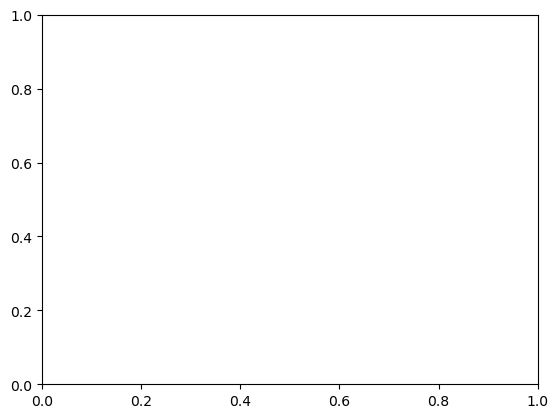

In [57]:
# your code here
# your code here
eps = [i for i in range(N_eps)]
plt.plot(eps,history.history['accuracy'],label="Train accuracy")
plt.plot(eps,history.history['val_accuracy'],label="Validation accuracy", color='red')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of number of Epochs")
plt.show()

<div class='exercise-r'>

**2.3.3**  In a few sentences, describe the various approaches you have taken to improve the performance of your regularized model in 2.3.1 as well as any observations you might have regarding your training and Kaggle results.


</div>

_Type your answer here, replacing this text._

<div class='exercise-r'>

**2.3.4**  Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS109B Kaggle Competition](#part2kaggle) for leaderboard scoring. **IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"Id"` and needs to contain the test observation index numbers corresponding to each of your 2,000 predictions (index starting at `0`), the second column must be named `"Category"` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. Both columns should contain integer data types.




</div>

In [ ]:
# your code here
...

<div class='exercise-r'>

**2.3.5**  **Specify your Kaggle name that you have used on the leaderboard**. We CANNOT give you credit without this.

</div>

_Type your answer here, replacing this text._

<!-- BEGIN QUESTION -->

<div class='exercise-r'><b>2.4 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

_Type your answer here, replacing this text._

In [ ]:
hours_spent_on_hw = ...

In [ ]:
grader.check("q2.4")

In [ ]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

**This concludes HW3. Thank you!**